Training set shape: (13440, 32, 32, 1)
Test set shape: (3360, 32, 32, 1)
Training labels shape: (13440, 29)
Test labels shape: (3360, 29)


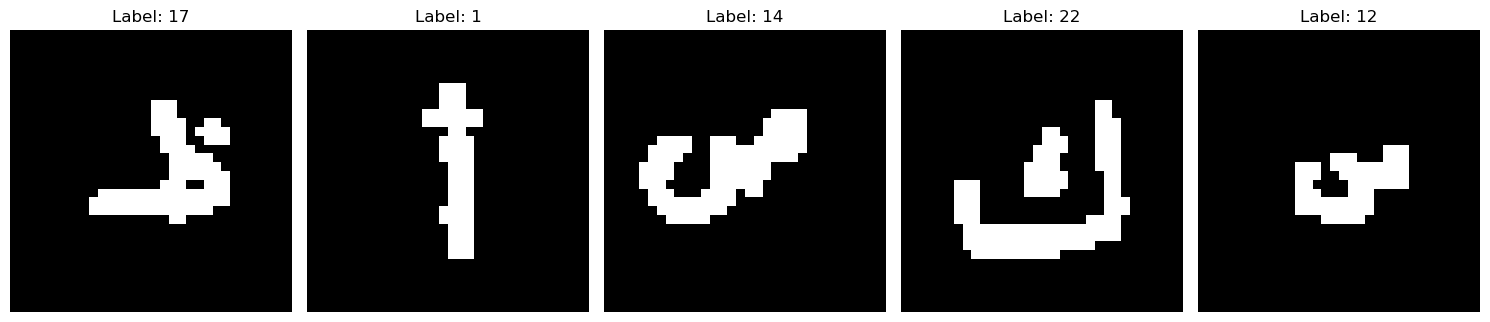

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Define paths
TRAIN_PATH = '/Users/rakan/Coding/Ironhack AI Engineering Bootcamp/Projects/Project 2 (Arabic MNIST)/arabic_mnist_dataset/train/train'
TEST_PATH = '/Users/rakan/Coding/Ironhack AI Engineering Bootcamp/Projects/Project 2 (Arabic MNIST)/arabic_mnist_dataset/test/test'

def load_dataset(path):
    images = []
    labels = []
    
    # Loop through all files in the directory
    for filename in os.listdir(path):
        if filename.endswith('.png'):
            # Extract label from filename
            label = int(filename.split('_label_')[1].split('.')[0])
            
            # Load and preprocess image
            img_path = os.path.join(path, filename)
            img = load_img(img_path, color_mode='grayscale', target_size=(32, 32))
            img_array = img_to_array(img)
            
            # Normalize pixel values
            img_array = img_array / 255.0
            
            images.append(img_array)
            labels.append(label)
    
    return np.array(images), np.array(labels)

# Load training and test sets
X_train, y_train = load_dataset(TRAIN_PATH)
X_test, y_test = load_dataset(TEST_PATH)

# Reshape images to be (samples, height, width, channels)
X_train = X_train.reshape((-1, 32, 32, 1))
X_test = X_test.reshape((-1, 32, 32, 1))

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Print dataset information
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

# Display some sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i].reshape(32, 32), cmap='gray')
    plt.title(f'Label: {np.argmax(y_train[i])}')
    plt.axis('off')
plt.tight_layout()
plt.show()

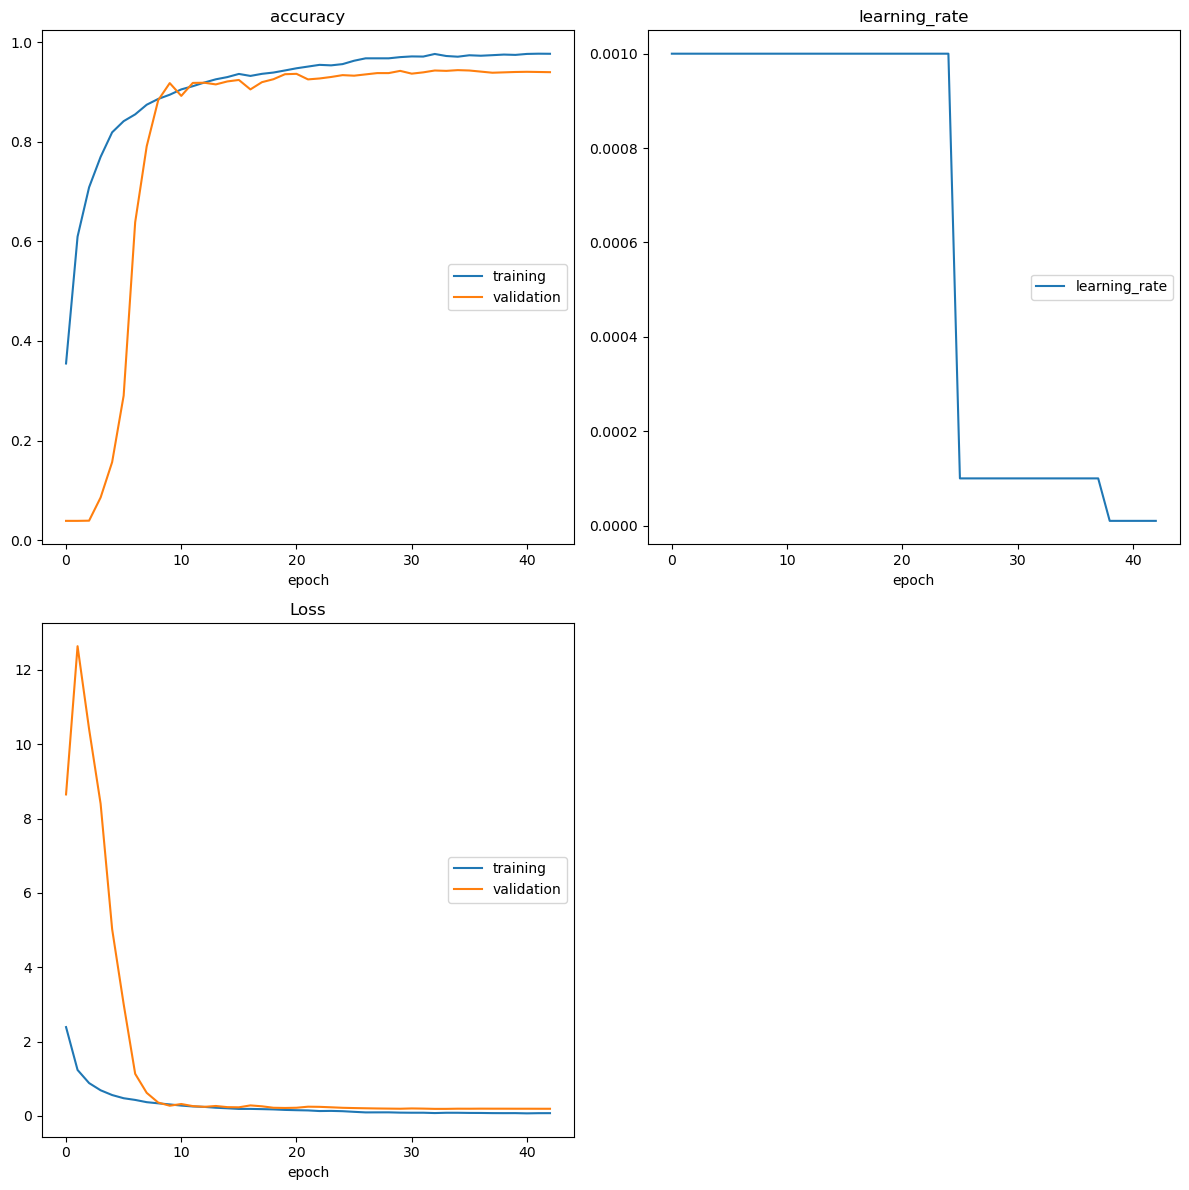

accuracy
	training         	 (min:    0.355, max:    0.977, cur:    0.977)
	validation       	 (min:    0.039, max:    0.944, cur:    0.940)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.001, cur:    0.000)
Loss
	training         	 (min:    0.070, max:    2.391, cur:    0.076)
	validation       	 (min:    0.191, max:   12.638, cur:    0.194)
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9778 - loss: 0.0726 - val_accuracy: 0.9397 - val_loss: 0.1935 - learning_rate: 1.0000e-05
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9483 - loss: 0.2082

Test accuracy: 0.9485


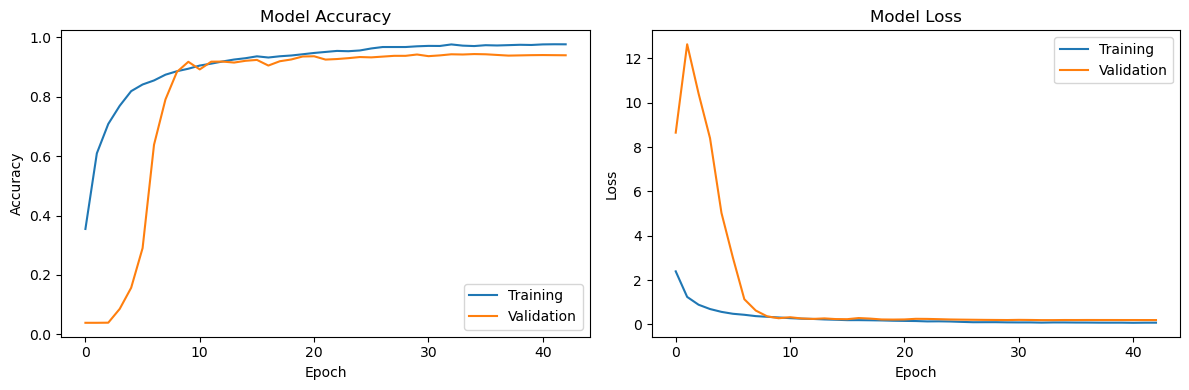

In [6]:
# Lets import what we need
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras


# First, let's check our data
print("Before processing:")
print("Number of unique labels in y_train:", len(np.unique(y_train)))
print("Shape of y_train:", y_train.shape)
print("Sample of y_train:", y_train[:5])

# Convert labels to categorical if they aren't already
if len(y_train.shape) == 1:  # If labels are not yet categorical
    num_classes = len(np.unique(y_train))
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

print("\nAfter processing:")
print("Shape of y_train:", y_train.shape)
print("Number of classes:", y_train.shape[1])

# Build the CNN model with the correct number of classes
def create_model(num_classes):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1), padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Dense Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Using the correct number of classes
    ])
    
    return model

# Create and compile the model with the correct number of classes
num_classes = y_train.shape[1]  # Get number of classes from processed labels
print(f"\nCreating model with {num_classes} output classes")

model = create_model(num_classes)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, PlotLossesKeras()]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


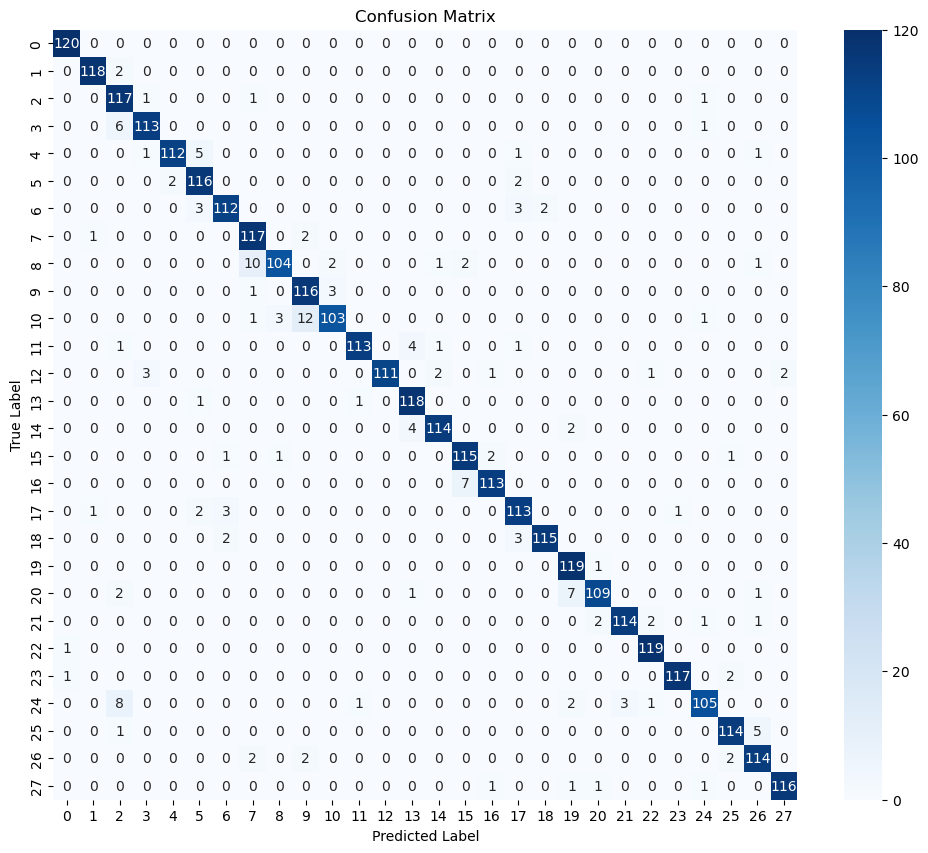

              precision    recall  f1-score   support

           1       0.98      1.00      0.99       120
           2       0.98      0.98      0.98       120
           3       0.85      0.97      0.91       120
           4       0.96      0.94      0.95       120
           5       0.98      0.93      0.96       120
           6       0.91      0.97      0.94       120
           7       0.95      0.93      0.94       120
           8       0.89      0.97      0.93       120
           9       0.96      0.87      0.91       120
          10       0.88      0.97      0.92       120
          11       0.95      0.86      0.90       120
          12       0.98      0.94      0.96       120
          13       1.00      0.93      0.96       120
          14       0.93      0.98      0.96       120
          15       0.97      0.95      0.96       120
          16       0.93      0.96      0.94       120
          17       0.97      0.94      0.95       120
          18       0.92    

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes))

In [10]:
# Save the model
model.save('arabic_mnist_model.keras')

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('arabic_mnist_model.keras')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


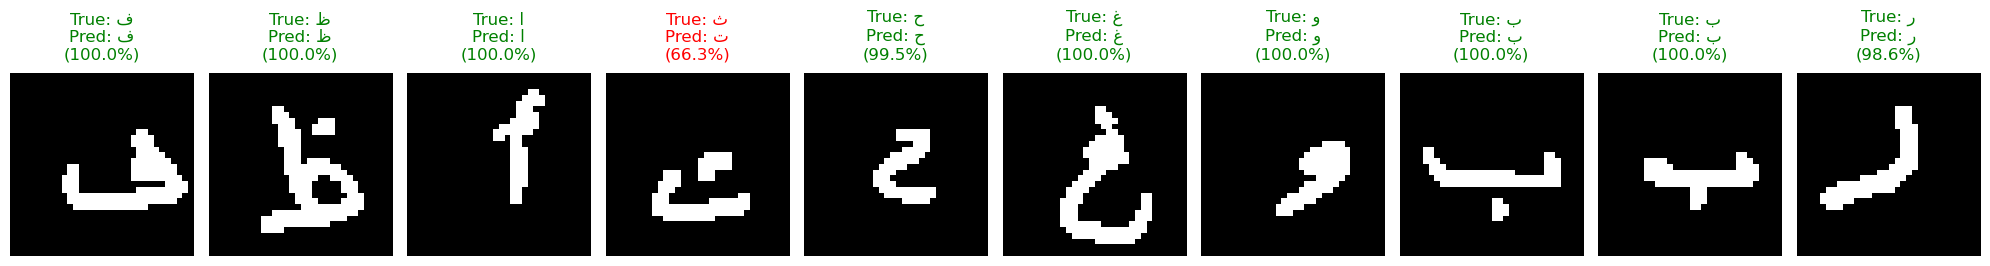

In [14]:
# Adjust the Arabic labels array by shifting it one position
arabic_labels = ['ي', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 
                'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 
                'ك', 'ل', 'م', 'ن', 'ه', 'و']

def predict_and_display(X_samples, y_true=None, num_images=5):
    # Make predictions
    predictions = model.predict(X_samples[:num_images])
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Create figure
    plt.figure(figsize=(20, 4))
    
    for i in range(num_images):
        # Display image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_samples[i].reshape(32, 32), cmap='gray')
        
        # Get prediction probability
        pred_prob = np.max(predictions[i]) * 100
        
        # Create title with prediction and probability
        title = f'Pred: {arabic_labels[predicted_classes[i]]}\n({pred_prob:.1f}%)'
        
        # Add true label if provided
        if y_true is not None:
            true_class = np.argmax(y_true[i])
            title = f'True: {arabic_labels[true_class]}\n' + title
            
            # Add color to title based on correctness
            if predicted_classes[i] == true_class:
                plt.title(title, color='green', pad=10)
            else:
                plt.title(title, color='red', pad=10)
        else:
            plt.title(title, pad=10)
            
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test on random samples from test set
random_indices = np.random.choice(len(X_test), size=10, replace=False)
X_samples = X_test[random_indices]
y_samples = y_test[random_indices]

# Display predictions
predict_and_display(X_samples, y_samples, num_images=10)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


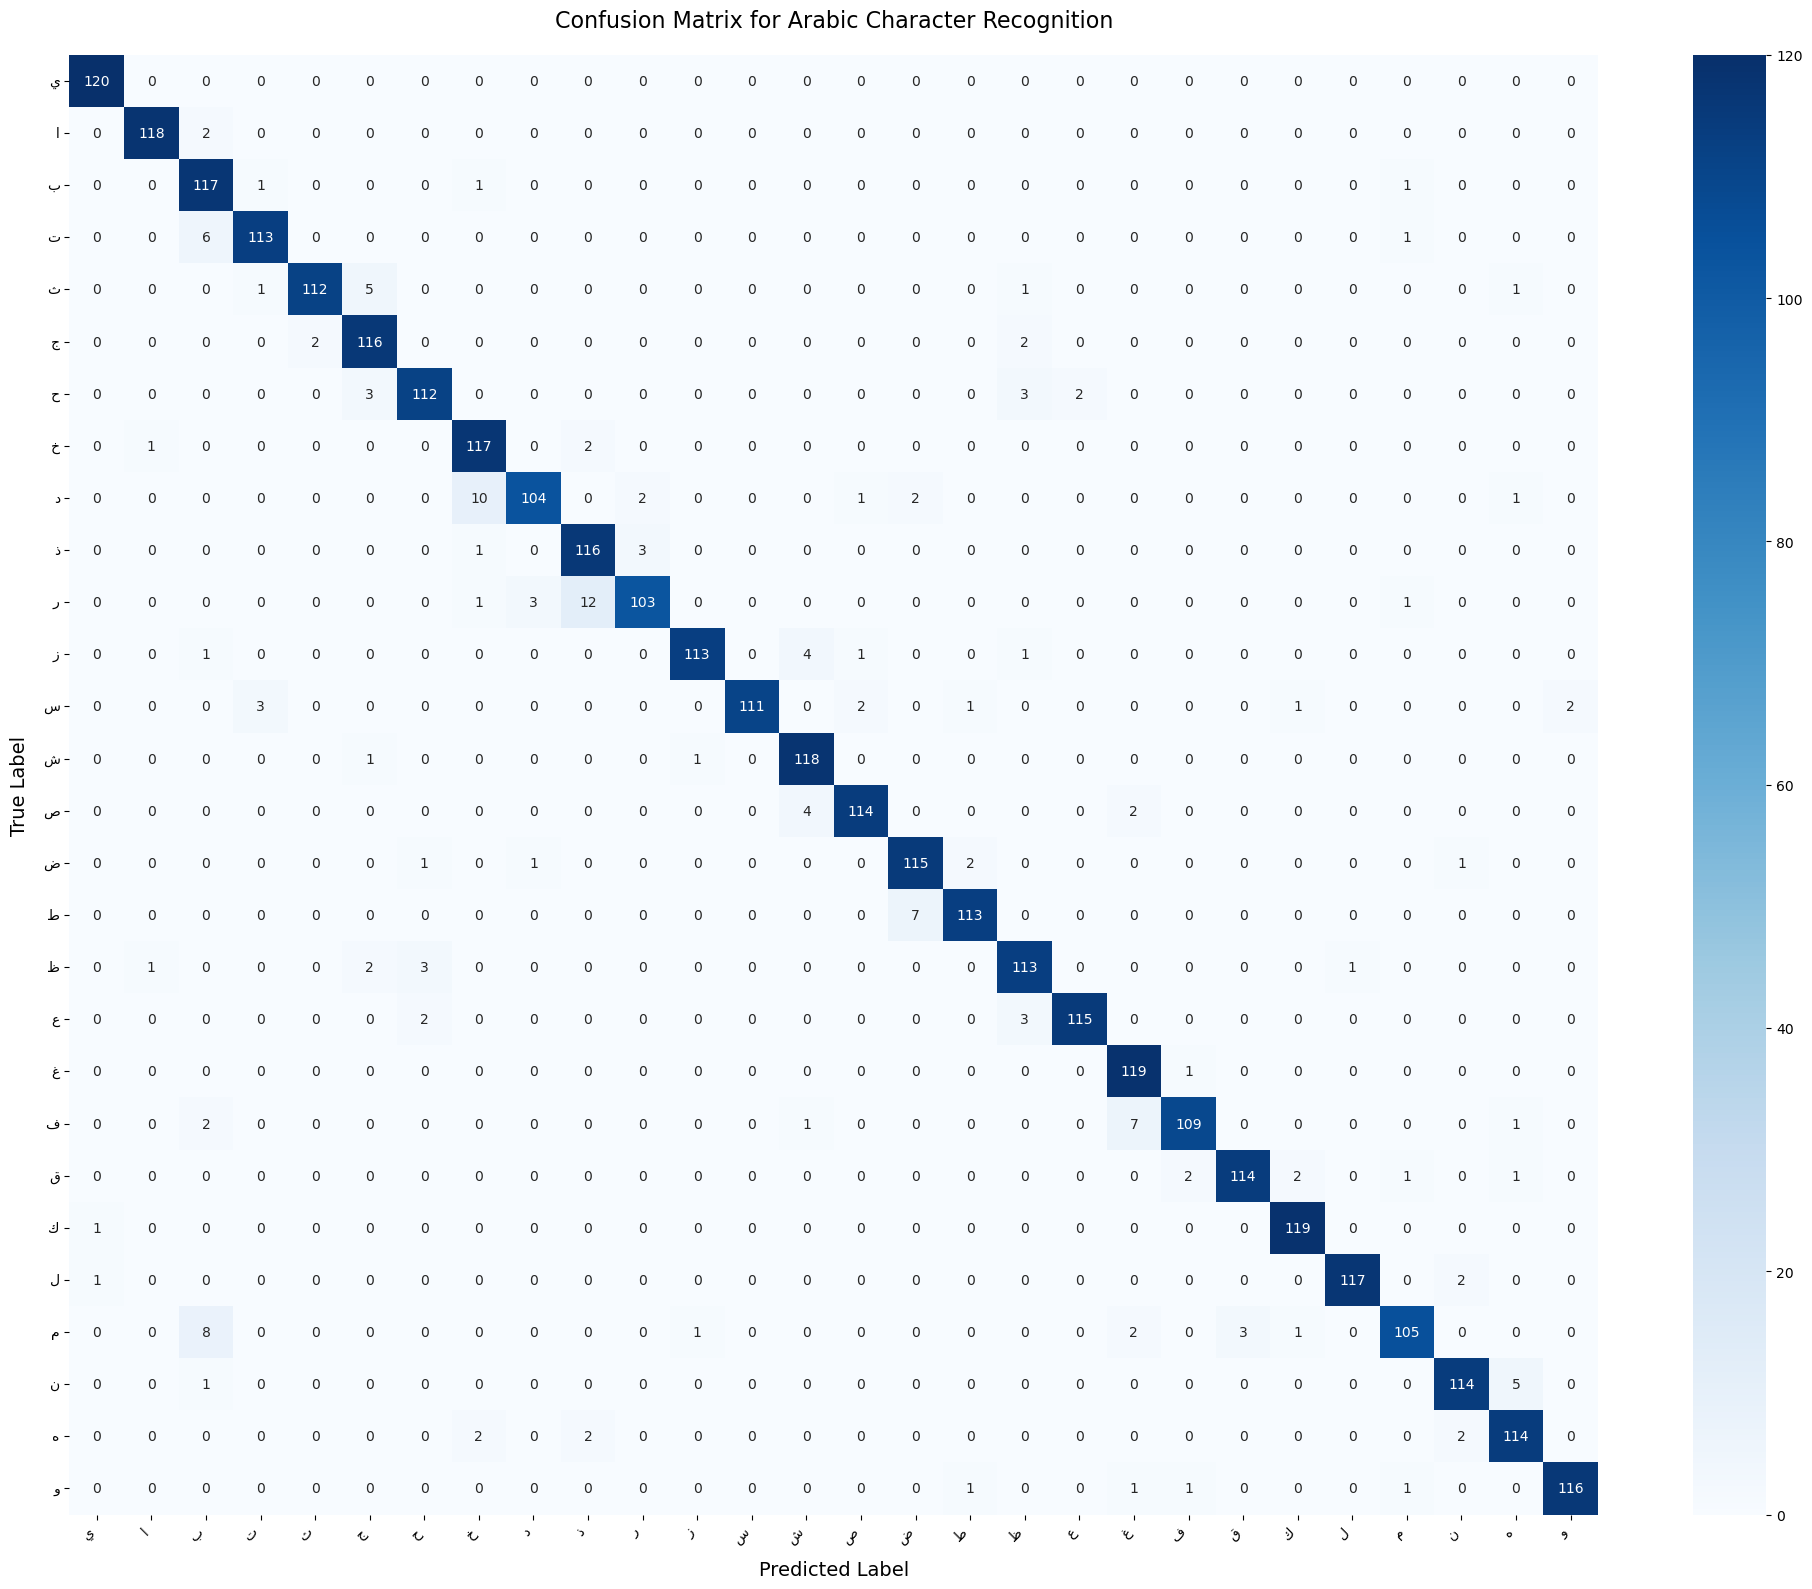


Classification Report:
              precision    recall  f1-score   support

           ي      0.984     1.000     0.992       120
           ا      0.983     0.983     0.983       120
           ب      0.854     0.975     0.911       120
           ت      0.958     0.942     0.950       120
           ث      0.982     0.933     0.957       120
           ج      0.913     0.967     0.939       120
           ح      0.949     0.933     0.941       120
           خ      0.886     0.975     0.929       120
           د      0.963     0.867     0.912       120
           ذ      0.879     0.967     0.921       120
           ر      0.954     0.858     0.904       120
           ز      0.983     0.942     0.962       120
           س      1.000     0.925     0.961       120
           ش      0.929     0.983     0.955       120
           ص      0.966     0.950     0.958       120
           ض      0.927     0.958     0.943       120
           ط      0.966     0.942     0.954       120
   

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Corrected Arabic letter labels
arabic_labels = ['ي', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 
                'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 
                'ك', 'ل', 'م', 'ن', 'ه', 'و']

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Create plot
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=arabic_labels,
            yticklabels=arabic_labels)

plt.title('Confusion Matrix for Arabic Character Recognition', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=14, labelpad=10)
plt.ylabel('True Label', fontsize=14, labelpad=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

# Print classification report with Arabic labels
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, 
                          target_names=arabic_labels,
                          digits=3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


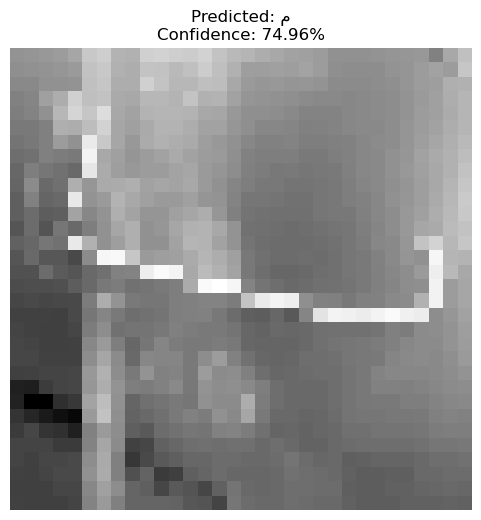

In [17]:
#image_path = '/Users/rakan/Desktop/Screenshot 2024-12-05 at 1.04.40 PM.png'

def preprocess_new_image(image_path):
    # Load and preprocess a new image
    img = tf.keras.preprocessing.image.load_img(
        image_path, color_mode='grayscale', target_size=(32, 32)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = img_array.reshape((1, 32, 32, 1))
    return img_array

def predict_new_image(image_path):
    # Preprocess the image
    processed_image = preprocess_new_image(image_path)
    
    # Make prediction
    prediction = model.predict(processed_image)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction) * 100
    
    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(processed_image.reshape(32, 32), cmap='gray')
    plt.title(f'Predicted: {arabic_labels[predicted_class]}\nConfidence: {confidence:.2f}%')
    plt.axis('off')
    plt.show()
    
#predict_new_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


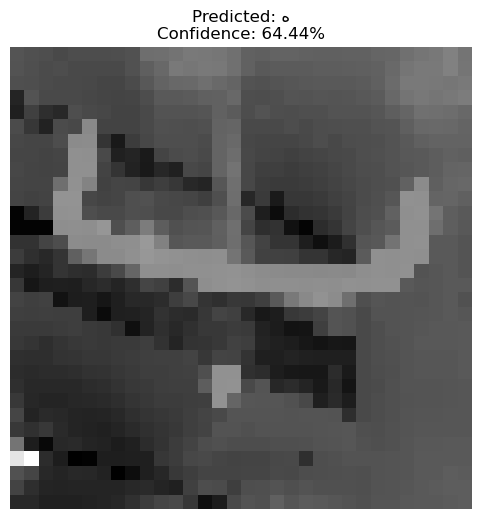

In [18]:
predict_new_image('/Users/rakan/Desktop/Screenshot 2024-12-05 at 1.08.29 PM.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


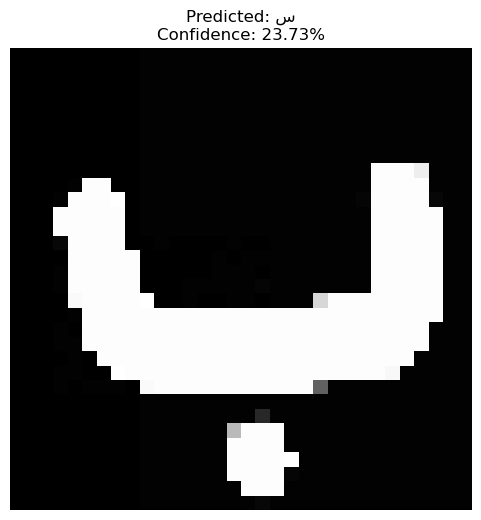

In [19]:
predict_new_image('/Users/rakan/Downloads/IMG_6132.jpg')

# Retraining the model with the new data (augmented data)

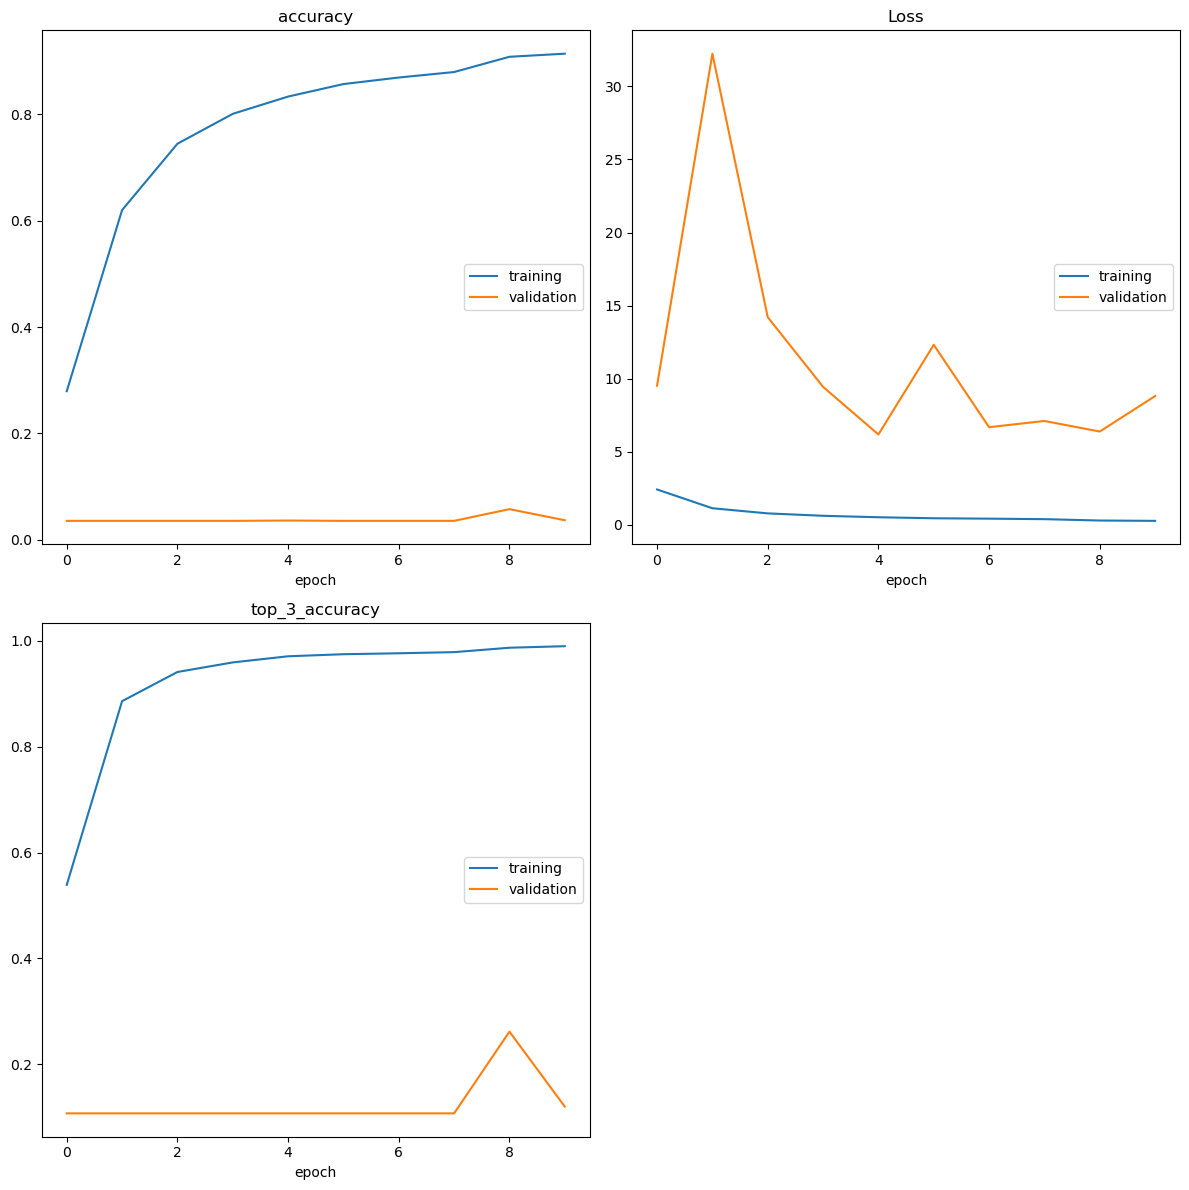

accuracy
	training         	 (min:    0.279, max:    0.914, cur:    0.914)
	validation       	 (min:    0.036, max:    0.058, cur:    0.037)
Loss
	training         	 (min:    0.276, max:    2.423, cur:    0.276)
	validation       	 (min:    6.185, max:   32.233, cur:    8.812)
top_3_accuracy
	training         	 (min:    0.539, max:    0.990, cur:    0.990)
	validation       	 (min:    0.107, max:    0.262, cur:    0.120)

Learning rate for epoch 10 is 0.000200

Epoch 10: val_accuracy did not improve from 0.05774
420/420 ━━━━━━━━━━━━━━━━━━━━ 84s 199ms/step - accuracy: 0.9138 - loss: 0.2743 - top_3_accuracy: 0.9912 - val_accuracy: 0.0369 - val_loss: 8.8120 - val_top_3_accuracy: 0.1199 - learning_rate: 2.0000e-04
Epoch 11/50
197/420 ━━━━━━━━━━━━━━━━━━━━ 39s 177ms/step - accuracy: 0.9135 - loss: 0.2693 - top_3_accuracy: 0.9904

KeyboardInterrupt: 

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  # Small rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    zoom_range=0.1,  # Zoom
    shear_range=0.1,  # Shear
    fill_mode='nearest',
    preprocessing_function=lambda x: x + np.random.normal(loc=0.0, scale=0.05, size=x.shape)  # Add Gaussian noise
)

# Create the generator
train_generator = datagen.flow(X_train, y_train, batch_size=32)

def create_improved_model():
    model = tf.keras.Sequential([
        # Input Layer with normalization
        tf.keras.layers.InputLayer(input_shape=(32, 32, 1)),
        tf.keras.layers.Rescaling(1./255),
        
        # First Convolutional Block - Capture fine details
        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        
        # Second Convolutional Block - Extract features
        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        
        # Third Convolutional Block - Higher level features
        tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        
        # Dense Layers for classification
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(29, activation='softmax')
    ])
    
    # Compile with a constant learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
    )
    
    return model

# Create model
model = create_improved_model()

# Print model summary
print("\nModel Summary:")
model.summary()

class LRLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Access the learning rate directly from the optimizer
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f'\nLearning rate for epoch {epoch+1} is {lr:.6f}')

# Train the model with all callbacks
history = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[
        PlotLossesKeras(),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        LRLogger(),
        tf.keras.callbacks.ModelCheckpoint(
            'best_arabic_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
)

# Plot additional training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# Print final evaluation
print("\nFinal Evaluation on Test Set:")
test_loss, test_accuracy, top_3_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Top-3 Accuracy: {top_3_accuracy:.4f}')

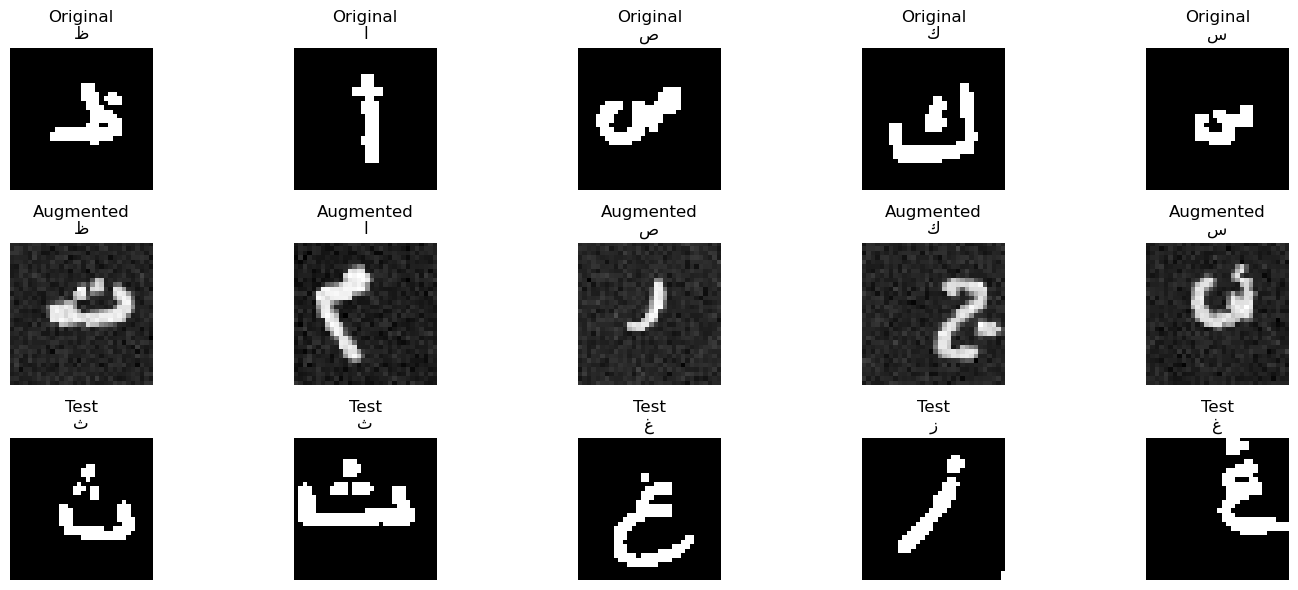


Data Shapes and Ranges:
Training data shape: (13440, 32, 32, 1)
Training data range: [0.000, 1.000]
Test data shape: (3360, 32, 32, 1)
Test data range: [0.000, 1.000]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step

Sample Predictions vs Actual:
Sample 1:
True: ث
Predicted: ه
Confidence: 66.49%

Sample 2:
True: ث
Predicted: و
Confidence: 52.09%

Sample 3:
True: غ
Predicted: ه
Confidence: 64.95%

Sample 4:
True: ز
Predicted: ه
Confidence: 39.24%

Sample 5:
True: غ
Predicted: و
Confidence: 47.73%



In [25]:
def plot_samples(original_data, augmented_data, test_data, n_samples=5):
    plt.figure(figsize=(15, 6))
    
    # Plot original training samples
    for i in range(n_samples):
        plt.subplot(3, n_samples, i + 1)
        plt.imshow(original_data[i].reshape(32, 32), cmap='gray')
        plt.title(f'Original\n{arabic_labels[np.argmax(y_train[i])]}')
        plt.axis('off')
    
    # Plot augmented samples
    augmented_batch = next(augmented_data)[0]
    for i in range(n_samples):
        plt.subplot(3, n_samples, n_samples + i + 1)
        plt.imshow(augmented_batch[i].reshape(32, 32), cmap='gray')
        plt.title(f'Augmented\n{arabic_labels[np.argmax(y_train[i])]}')
        plt.axis('off')
    
    # Plot test samples
    for i in range(n_samples):
        plt.subplot(3, n_samples, 2*n_samples + i + 1)
        plt.imshow(test_data[i].reshape(32, 32), cmap='gray')
        plt.title(f'Test\n{arabic_labels[np.argmax(y_test[i])]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot samples
plot_samples(X_train, train_generator, X_test)

# Print shapes and value ranges
print("\nData Shapes and Ranges:")
print(f"Training data shape: {X_train.shape}")
print(f"Training data range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"Test data shape: {X_test.shape}")
print(f"Test data range: [{X_test.min():.3f}, {X_test.max():.3f}]")

# Print a sample of actual vs predicted values
predictions = model.predict(X_test[:5])
print("\nSample Predictions vs Actual:")
for i in range(5):
    true_label = arabic_labels[np.argmax(y_test[i])]
    pred_label = arabic_labels[np.argmax(predictions[i])]
    confidence = np.max(predictions[i]) * 100
    print(f"Sample {i+1}:")
    print(f"True: {true_label}")
    print(f"Predicted: {pred_label}")
    print(f"Confidence: {confidence:.2f}%\n")

Verifying Original and Augmented Data Labels:


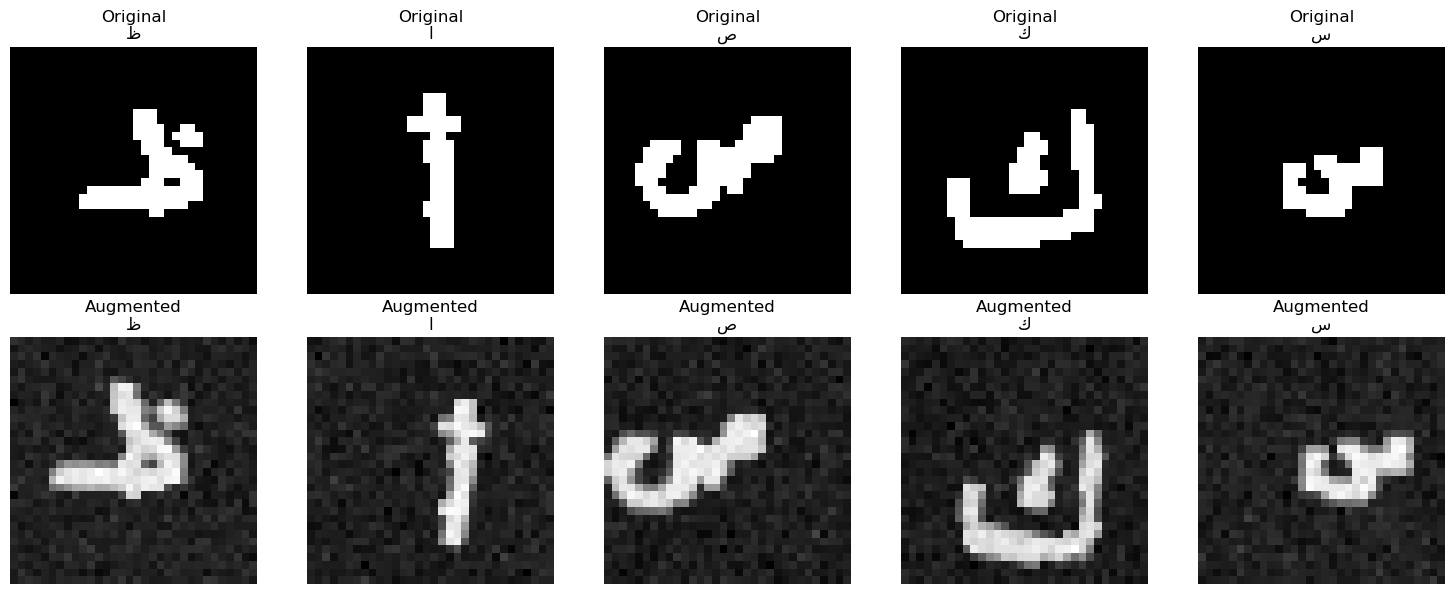

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Data Augmentation with shuffle=False to maintain label correspondence
datagen = ImageDataGenerator(
    rotation_range=10,  # Small rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    zoom_range=0.1,  # Zoom
    shear_range=0.1,  # Shear
    fill_mode='nearest',
    preprocessing_function=lambda x: x + np.random.normal(loc=0.0, scale=0.05, size=x.shape)  # Add Gaussian noise
)

# Create the generator with shuffle=False
train_generator = datagen.flow(
    X_train, 
    y_train,
    batch_size=32,
    shuffle=False,  # Important: keep false for verification
    seed=42
)

# Function to plot samples
def plot_samples(original_data, original_labels, augmented_data, augmented_labels, arabic_labels, n_samples=5):
    plt.figure(figsize=(15, 6))
    
    # Plot original training samples
    for i in range(n_samples):
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(original_data[i].reshape(32, 32), cmap='gray')
        true_label = arabic_labels[np.argmax(original_labels[i])]
        plt.title(f'Original\n{true_label}')
        plt.axis('off')
    
    # Plot augmented samples
    for i in range(n_samples):
        plt.subplot(2, n_samples, n_samples + i + 1)
        plt.imshow(augmented_data[i].reshape(32, 32), cmap='gray')
        true_label = arabic_labels[np.argmax(augmented_labels[i])]
        plt.title(f'Augmented\n{true_label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Verify original and augmented data labels
print("Verifying Original and Augmented Data Labels:")

# Get a batch of augmented images and their labels
augmented_images, augmented_labels = next(train_generator)

# Plot samples
plot_samples(X_train, y_train, augmented_images, augmented_labels, arabic_labels)

Number of classes in arabic_labels: 28
Shape of label data: 29

Random Samples of Augmented Data:


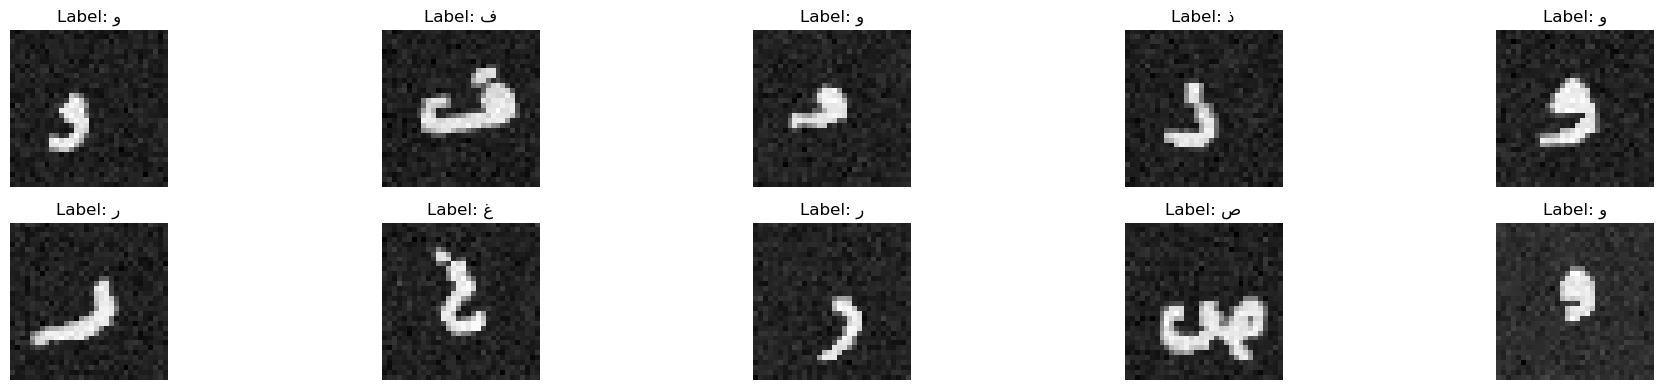


Detailed Sample Information:
Sample 1: Label: و
Top predictions:
  1. و: 1.000
  2. ش: 0.000

Sample 2: Label: ف
Top predictions:
  1. ف: 1.000
  2. ش: 0.000

Sample 3: Label: و
Top predictions:
  1. و: 1.000
  2. ش: 0.000

Sample 4: Label: ذ
Top predictions:
  1. ذ: 1.000
  2. ش: 0.000

Sample 5: Label: و
Top predictions:
  1. و: 1.000
  2. ش: 0.000

Sample 6: Label: ر
Top predictions:
  1. ر: 1.000
  2. ش: 0.000

Sample 7: Label: غ
Top predictions:
  1. غ: 1.000
  2. ش: 0.000

Sample 8: Label: ر
Top predictions:
  1. ر: 1.000
  2. ش: 0.000

Sample 9: Label: ص
Top predictions:
  1. ص: 1.000
  2. ش: 0.000
  3. ا: 0.000

Sample 10: Label: و
Top predictions:
  1. و: 1.000
  2. ش: 0.000



In [28]:
def plot_random_augmented_samples(generator, arabic_labels, n_samples=10):
    # Get multiple batches to have more samples to choose from
    all_images = []
    all_labels = []
    for _ in range(3):  # Get 3 batches
        images, labels = next(generator)
        all_images.extend(images)
        all_labels.extend(labels)
    
    # Convert to numpy arrays
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    
    # Generate random indices
    total_samples = len(all_images)
    random_indices = np.random.choice(total_samples, n_samples, replace=False)
    
    # Plot
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, n_samples//2, i + 1)
        plt.imshow(all_images[idx].reshape(32, 32), cmap='gray')
        true_label = arabic_labels[np.argmax(all_labels[idx])]
        plt.title(f'Label: {true_label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print details of the samples
    print("\nDetailed Sample Information:")
    for i, idx in enumerate(random_indices):
        true_label = arabic_labels[np.argmax(all_labels[idx])]
        print(f"Sample {i+1}: Label: {true_label}")
        
        # Get indices of top 3 predictions and their probabilities
        pred_indices = np.argsort(all_labels[idx])[-3:][::-1]
        pred_indices = [i for i in pred_indices if i < len(arabic_labels)]  # Ensure index is valid
        
        print("Top predictions:")
        for j, index in enumerate(pred_indices):
            if index < len(arabic_labels):  # Additional safety check
                print(f"  {j+1}. {arabic_labels[index]}: {all_labels[idx][index]:.3f}")
        print()

# Reset the generator
train_generator = datagen.flow(
    X_train, 
    y_train,
    batch_size=32,
    shuffle=False,
    seed=42
)

# Print the number of classes for verification
print(f"Number of classes in arabic_labels: {len(arabic_labels)}")
print(f"Shape of label data: {y_train.shape[1]}")

# Plot random samples
print("\nRandom Samples of Augmented Data:")
plot_random_augmented_samples(train_generator, arabic_labels)

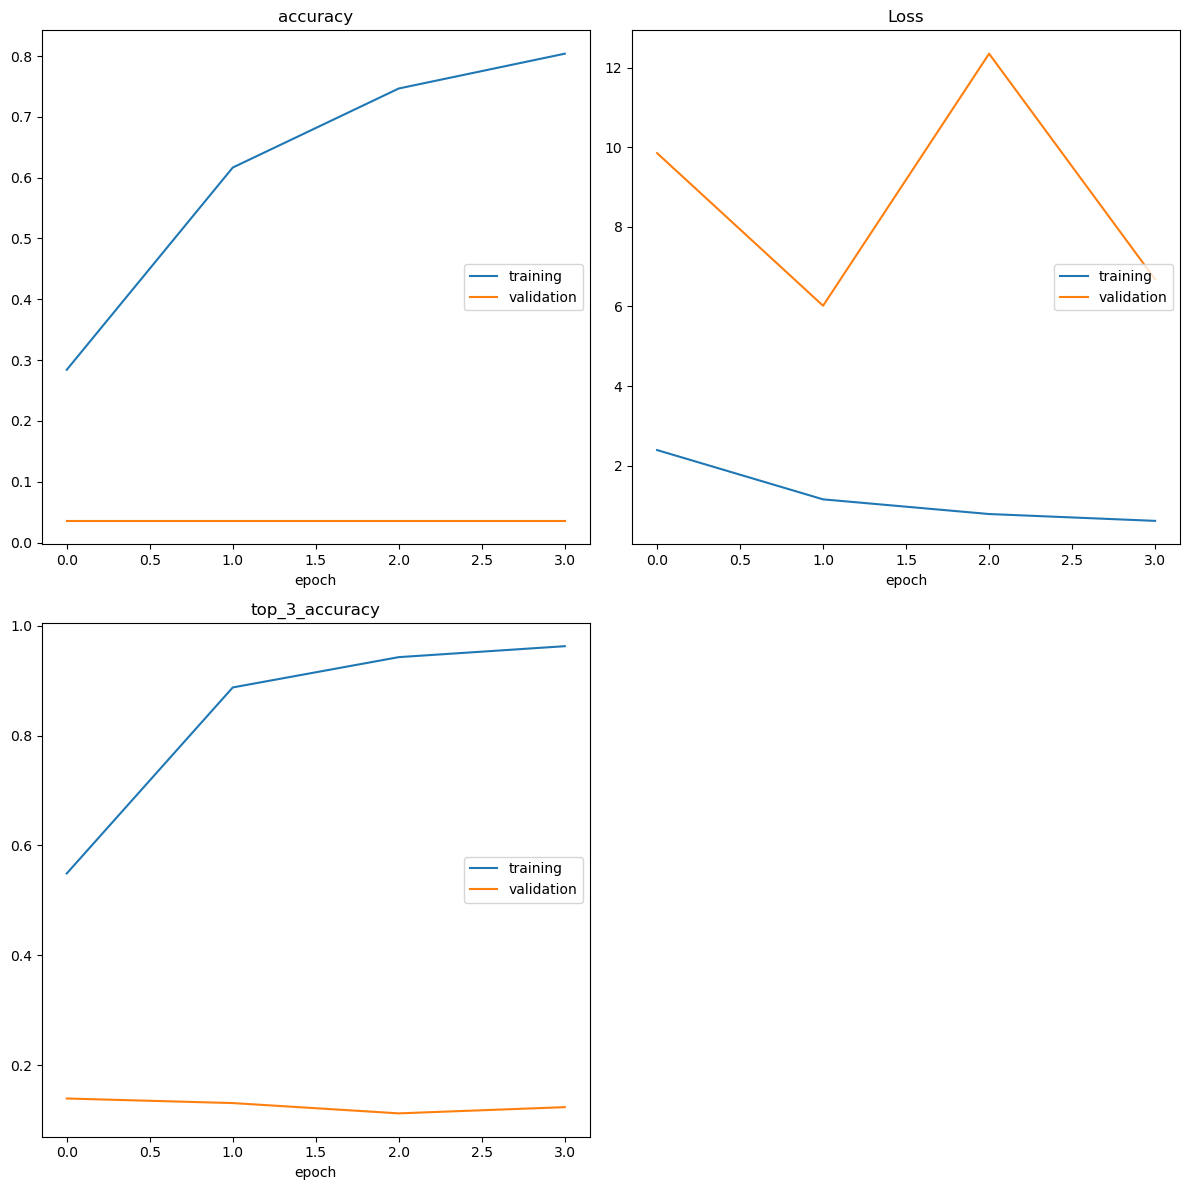

accuracy
	training         	 (min:    0.284, max:    0.804, cur:    0.804)
	validation       	 (min:    0.036, max:    0.036, cur:    0.036)
Loss
	training         	 (min:    0.614, max:    2.393, cur:    0.614)
	validation       	 (min:    6.017, max:   12.347, cur:    6.681)
top_3_accuracy
	training         	 (min:    0.549, max:    0.963, cur:    0.963)
	validation       	 (min:    0.112, max:    0.139, cur:    0.123)

Learning rate for epoch 4 is 0.001000

Epoch 4: val_accuracy did not improve from 0.03571
420/420 ━━━━━━━━━━━━━━━━━━━━ 73s 173ms/step - accuracy: 0.7990 - loss: 0.6287 - top_3_accuracy: 0.9622 - val_accuracy: 0.0357 - val_loss: 6.6809 - val_top_3_accuracy: 0.1232 - learning_rate: 0.0010
Epoch 5/50
393/420 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.8330 - loss: 0.5215 - top_3_accuracy: 0.9695

KeyboardInterrupt: 

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt

# Data Augmentation with shuffle=False to maintain label correspondence
datagen = ImageDataGenerator(
    rotation_range=10,  # Small rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    zoom_range=0.1,  # Zoom
    shear_range=0.1,  # Shear
    fill_mode='nearest',
    preprocessing_function=lambda x: x + np.random.normal(loc=0.0, scale=0.05, size=x.shape)  # Add Gaussian noise
)

# Create the generator with shuffle=False
train_generator = datagen.flow(
    X_train, 
    y_train,
    batch_size=32,
    shuffle=True,  # Set to True for training
    seed=42
)

def create_improved_model():
    model = tf.keras.Sequential([
        # Input Layer with normalization
        tf.keras.layers.InputLayer(input_shape=(32, 32, 1)),
        tf.keras.layers.Rescaling(1./255),
        
        # First Convolutional Block - Capture fine details
        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        
        # Second Convolutional Block - Extract features
        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        
        # Third Convolutional Block - Higher level features
        tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        
        # Dense Layers for classification
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(29, activation='softmax')
    ])
    
    # Compile with a constant learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
    )
    
    return model

# Create model
model = create_improved_model()

# Print model summary
print("\nModel Summary:")
model.summary()

class LRLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Access the learning rate directly from the optimizer
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f'\nLearning rate for epoch {epoch+1} is {lr:.6f}')

# Train the model with all callbacks
history = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[
        PlotLossesKeras(),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        LRLogger(),
        tf.keras.callbacks.ModelCheckpoint(
            'best_arabic_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
)

# Plot additional training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# Print final evaluation
print("\nFinal Evaluation on Test Set:")
test_loss, test_accuracy, top_3_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Top-3 Accuracy: {top_3_accuracy:.4f}')

In [31]:
# Check data ranges and shapes
print("Data Ranges:")
print(f"X_train range: [{X_train.min()}, {X_train.max()}]")
print(f"X_test range: [{X_test.min()}, {X_test.max()}]")
print("\nShapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Check label distribution without trying to map to arabic_labels
print("\nLabel Distribution in Training Set:")
train_labels = np.argmax(y_train, axis=1)
unique, counts = np.unique(train_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count}")

# Print available arabic labels
print("\nAvailable Arabic Labels:")
print(f"Number of arabic labels: {len(arabic_labels)}")
print("Labels:", arabic_labels)

# Print unique label indices
print("\nUnique label indices in training set:", sorted(unique))

Data Ranges:
X_train range: [0.0, 1.0]
X_test range: [0.0, 1.0]

Shapes:
X_train shape: (13440, 32, 32, 1)
y_train shape: (13440, 29)
X_test shape: (3360, 32, 32, 1)
y_test shape: (3360, 29)

Label Distribution in Training Set:
Label 1: 480
Label 2: 480
Label 3: 480
Label 4: 480
Label 5: 480
Label 6: 480
Label 7: 480
Label 8: 480
Label 9: 480
Label 10: 480
Label 11: 480
Label 12: 480
Label 13: 480
Label 14: 480
Label 15: 480
Label 16: 480
Label 17: 480
Label 18: 480
Label 19: 480
Label 20: 480
Label 21: 480
Label 22: 480
Label 23: 480
Label 24: 480
Label 25: 480
Label 26: 480
Label 27: 480
Label 28: 480

Available Arabic Labels:
Number of arabic labels: 28
Labels: ['ي', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و']

Unique label indices in training set: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


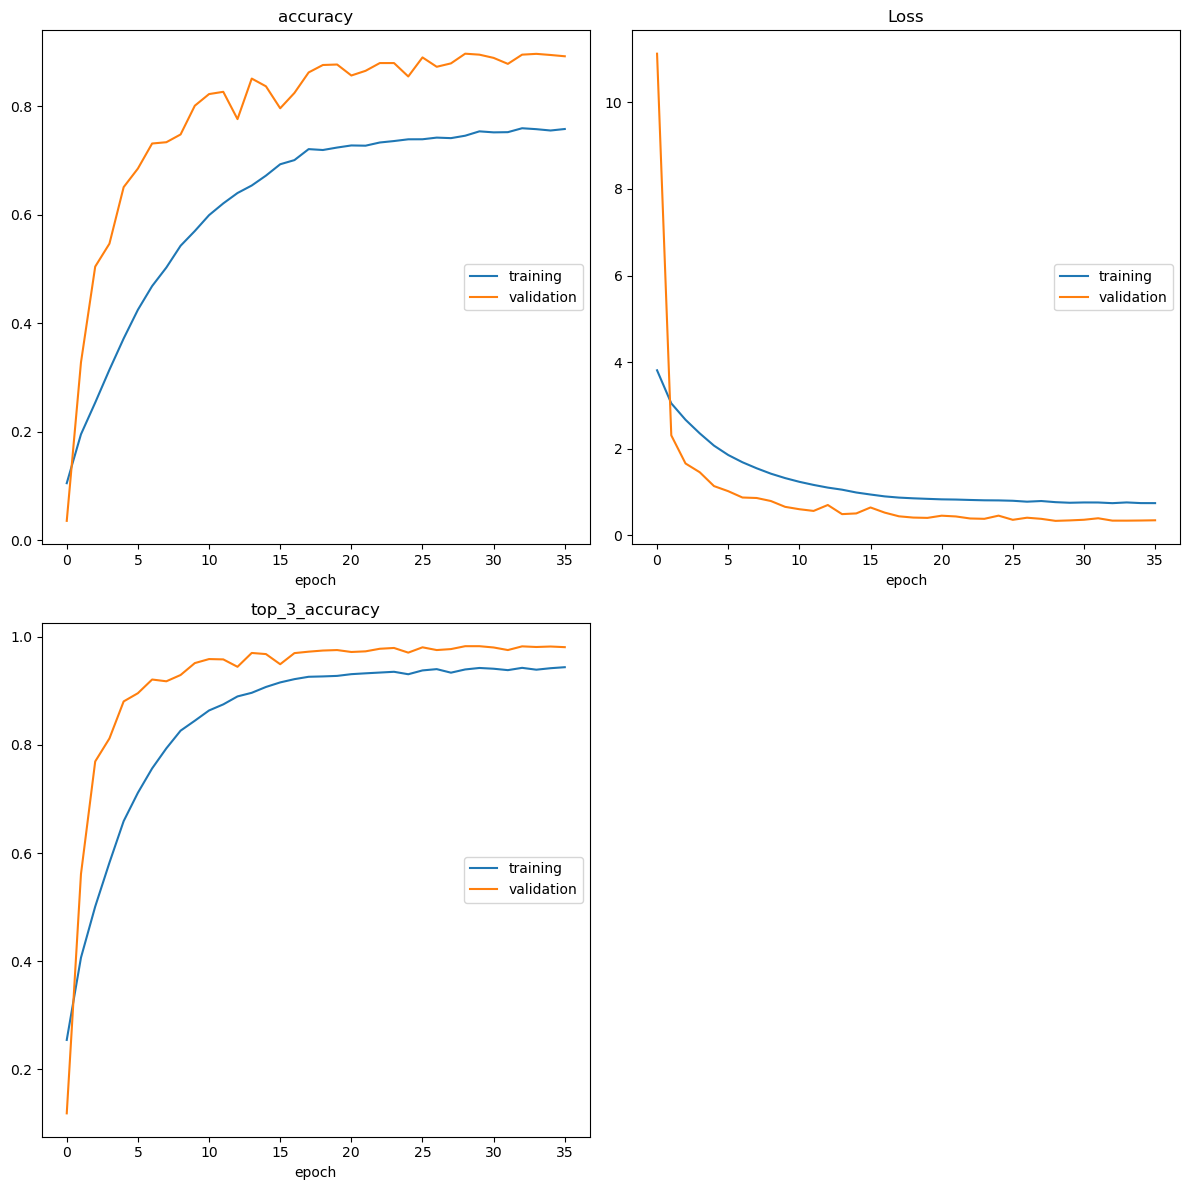

accuracy
	training         	 (min:    0.105, max:    0.759, cur:    0.758)
	validation       	 (min:    0.036, max:    0.896, cur:    0.892)
Loss
	training         	 (min:    0.742, max:    3.811, cur:    0.742)
	validation       	 (min:    0.333, max:   11.124, cur:    0.346)
top_3_accuracy
	training         	 (min:    0.255, max:    0.944, cur:    0.944)
	validation       	 (min:    0.119, max:    0.982, cur:    0.981)

Learning rate for epoch 36 is 0.000001

Epoch 36: val_accuracy did not improve from 0.89643
420/420 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.7571 - loss: 0.7478 - top_3_accuracy: 0.9427 - val_accuracy: 0.8917 - val_loss: 0.3461 - val_top_3_accuracy: 0.9807 - learning_rate: 1.0000e-06
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 29.


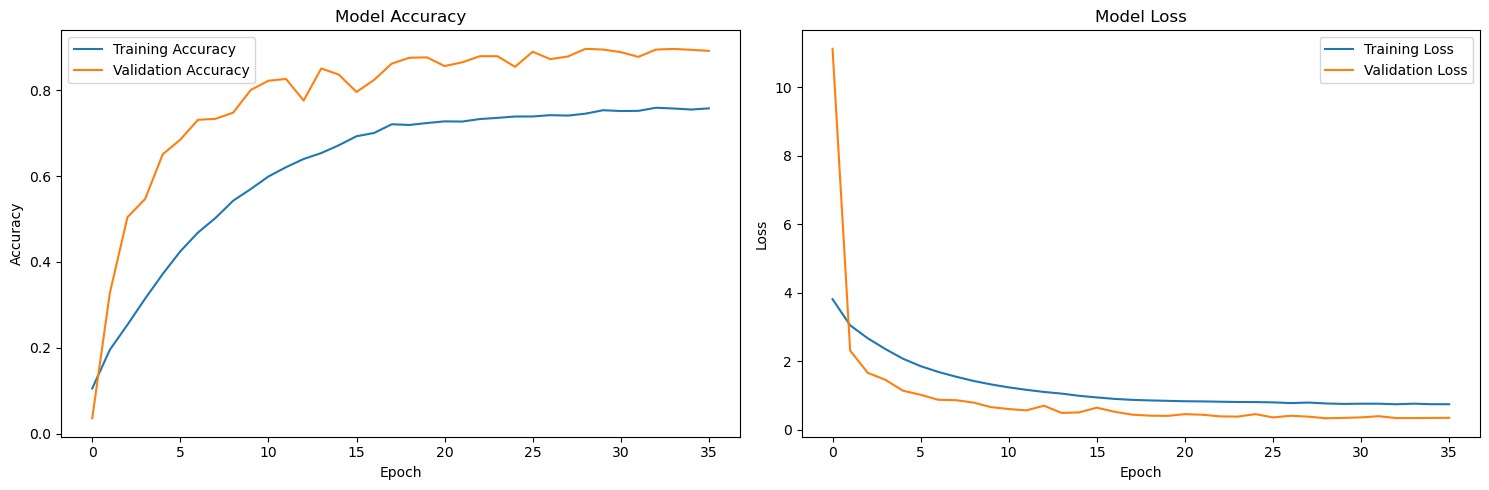


Final Evaluation on Test Set:
Test Accuracy: 0.8964
Top-3 Accuracy: 0.9824
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

Sample Predictions:
True label index: 4, Predicted label index: 4
True label index: 4, Predicted label index: 4
True label index: 19, Predicted label index: 19
True label index: 11, Predicted label index: 11
True label index: 19, Predicted label index: 19


In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest',
    preprocessing_function=lambda x: x + np.random.normal(loc=0.0, scale=0.05, size=x.shape)
)

# Create the generator
train_generator = datagen.flow(
    X_train, 
    y_train,
    batch_size=32,
    shuffle=True,
    seed=42
)

def create_model():
    model = tf.keras.Sequential([
        # Input Layer
        tf.keras.layers.InputLayer(input_shape=(32, 32, 1)),
        tf.keras.layers.Rescaling(1./255),
        
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(29, activation='softmax')
    ])
    
    # Compile with a smaller learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
    )
    
    return model

# Create model
model = create_model()
print("\nModel Summary:")
model.summary()

# Learning Rate Logger
class LRLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f'\nLearning rate for epoch {epoch+1} is {lr:.6f}')

# Train the model
history = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[
        PlotLossesKeras(),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        LRLogger(),
        tf.keras.callbacks.ModelCheckpoint(
            'best_arabic_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
)

# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# Print final evaluation
print("\nFinal Evaluation on Test Set:")
test_loss, test_accuracy, top_3_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Top-3 Accuracy: {top_3_accuracy:.4f}')

# Check predictions on a few samples
predictions = model.predict(X_test[:5])
print("\nSample Predictions:")
for i in range(5):
    true_label = np.argmax(y_test[i])
    pred_label = np.argmax(predictions[i])
    print(f"True label index: {true_label}, Predicted label index: {pred_label}")

In [38]:
def preprocess_new_image(image_path):
    # Load and preprocess a new image
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        color_mode='grayscale', 
        target_size=(32, 32)
    )
    
    # Convert to array and normalize
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

def predict_new_image(image_path, model, arabic_labels, top_k=3):
    # Preprocess the image
    processed_image = preprocess_new_image(image_path)
    
    # Make prediction
    predictions = model.predict(processed_image, verbose=0)
    
    # Get top k predictions
    top_k_indices = np.argsort(predictions[0])[-top_k:][::-1]
    top_k_probabilities = predictions[0][top_k_indices]
    
    # Display results
    plt.figure(figsize=(8, 6))
    
    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(processed_image.reshape(32, 32), cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    # Plot the predictions
    plt.subplot(1, 2, 2)
    plt.barh(range(top_k), top_k_probabilities * 100)
    
    # Use arabic_labels for the plot
    plt.yticks(range(top_k), [arabic_labels[i] for i in top_k_indices])
    
    plt.xlabel('Confidence (%)')
    plt.title('Top Predictions')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\nDetailed Predictions:")
    print("-" * 40)
    for i, (idx, prob) in enumerate(zip(top_k_indices, top_k_probabilities), 1):
        label = arabic_labels[idx]  # Use the correct Arabic label
        print(f"{i}. {label}")
        print(f"   Confidence: {prob * 100:.2f}%")
    
    return top_k_indices, top_k_probabilities

# Example usage:
# Load the best model
best_model = tf.keras.models.load_model('best_arabic_model.keras')

# Define your arabic_labels list
arabic_labels = [
    'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 
    'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 
    'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'لا'
]

# Make prediction
# image_path = 'path/to/your/image.png'
# predict_new_image(image_path, best_model, arabic_labels)

IndexError: list index out of range

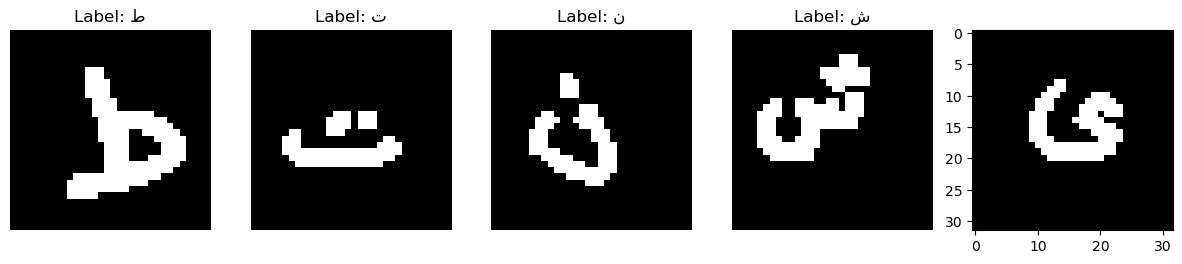

In [42]:
def plot_sample_images_with_labels(X_data, y_data, arabic_labels, n_samples=10):
    plt.figure(figsize=(15, 6))
    
    # Randomly select indices
    indices = np.random.choice(len(X_data), n_samples, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(2, n_samples // 2, i + 1)
        plt.imshow(X_data[idx].reshape(32, 32), cmap='gray')
        true_label_index = np.argmax(y_data[idx])
        true_label = arabic_labels[true_label_index]
        plt.title(f'Label: {true_label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Define your arabic_labels list
arabic_labels = [
     'ي', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 
    'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 
    'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و'
]

# Plot sample images with labels
plot_sample_images_with_labels(X_train, y_train, arabic_labels)

# loading the image from url

# ![Arabic Alphabet](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.lebanesearabicinstitute.com%2Farabic-alphabet%2F&psig=AOvVaw3z4zKWqm4IUa6akSZ7BRib&ust=1733495433164000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCLD27-3rkIoDFQAAAAAdAAAAABAE)


https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.lebanesearabicinstitute.com%2Farabic-alphabet%2F&psig=AOvVaw3z4zKWqm4IUa6akSZ7BRib&ust=1733495433164000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCLD27-3rkIoDFQAAAAAdAAAAABAE

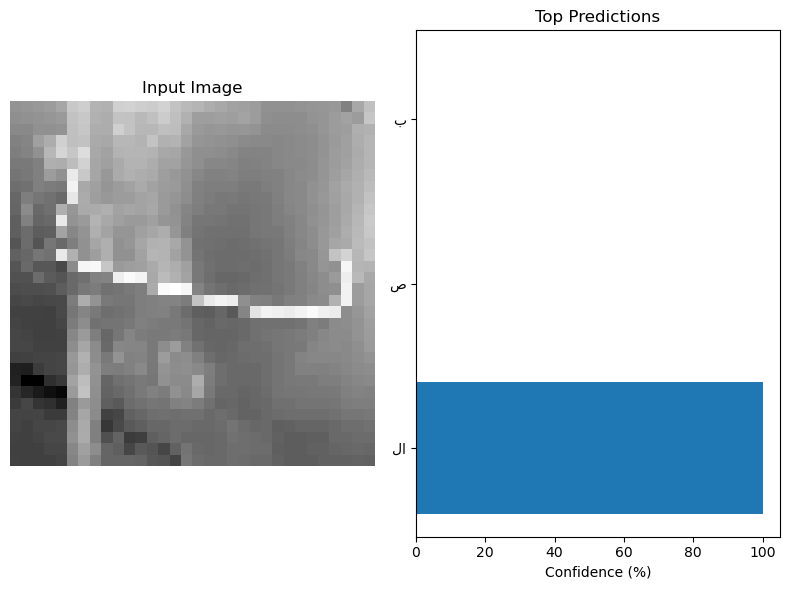


Detailed Predictions:
----------------------------------------
1. لا
   Confidence: 100.00%
2. ص
   Confidence: 0.00%
3. ب
   Confidence: 0.00%


(array([28, 13,  1]), array([1., 0., 0.], dtype=float32))

In [40]:
arabic_labels = [
    'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 
    'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 
    'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'لا'
]

predict_new_image('/Users/rakan/Desktop/Screenshot 2024-12-05 at 1.04.40 PM.png', best_model, arabic_labels)

IndexError: list index out of range

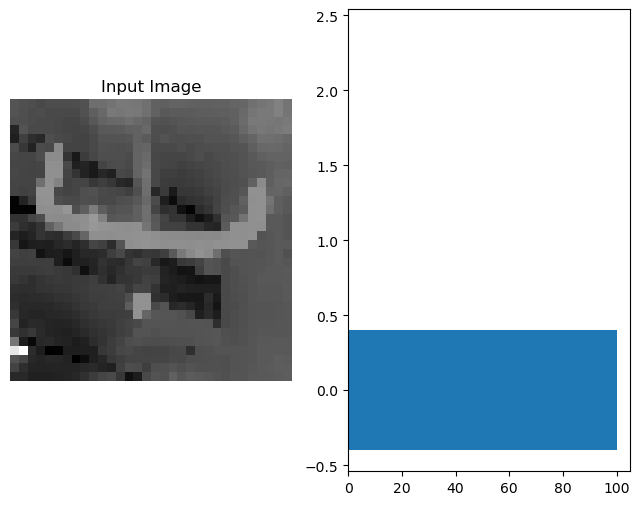

In [44]:
predict_new_image('/Users/rakan/Desktop/Screenshot 2024-12-05 at 1.08.29 PM.png', best_model, arabic_labels)

IndexError: list index out of range

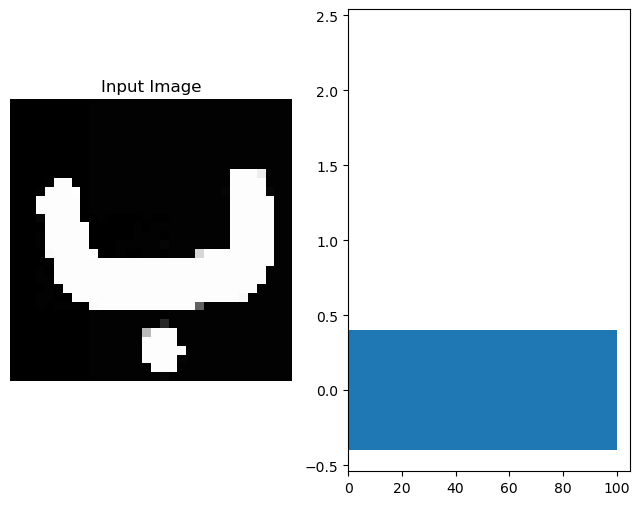

In [45]:
predict_new_image('/Users/rakan/Downloads/IMG_6132.jpg', best_model, arabic_labels)

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


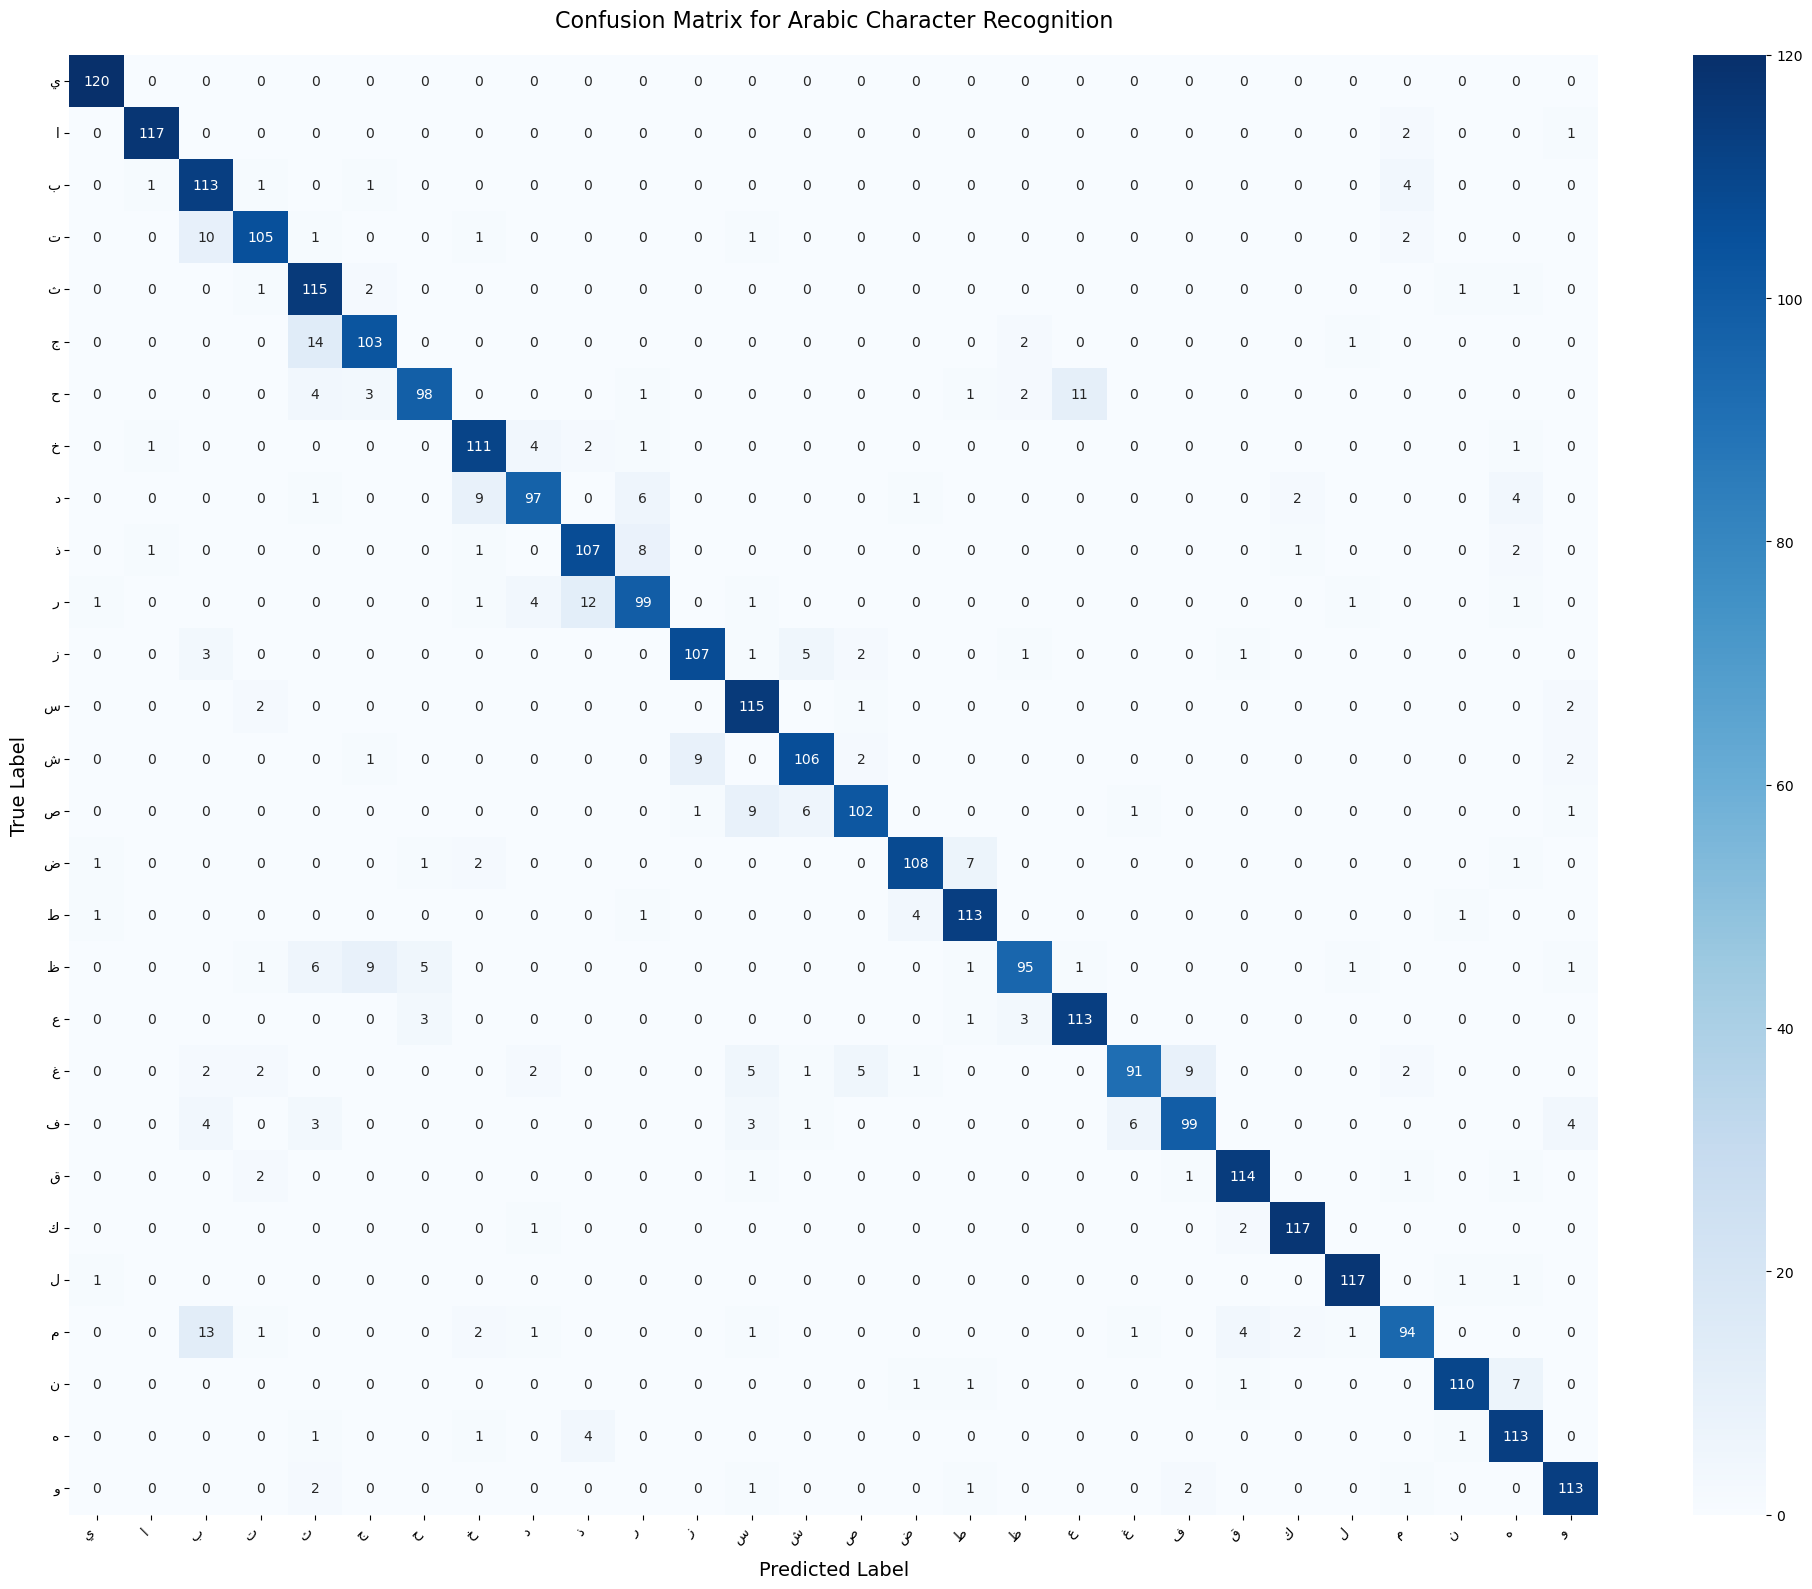


Classification Report:
              precision    recall  f1-score   support

           ي      0.968     1.000     0.984       120
           ا      0.975     0.975     0.975       120
           ب      0.779     0.942     0.853       120
           ت      0.913     0.875     0.894       120
           ث      0.782     0.958     0.861       120
           ج      0.866     0.858     0.862       120
           ح      0.916     0.817     0.863       120
           خ      0.867     0.925     0.895       120
           د      0.890     0.808     0.847       120
           ذ      0.856     0.892     0.873       120
           ر      0.853     0.825     0.839       120
           ز      0.915     0.892     0.903       120
           س      0.833     0.958     0.891       120
           ش      0.891     0.883     0.887       120
           ص      0.911     0.850     0.879       120
           ض      0.939     0.900     0.919       120
           ط      0.904     0.942     0.922       120
   

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Corrected Arabic letter labels
arabic_labels = ['ي', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 
                'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 
                'ك', 'ل', 'م', 'ن', 'ه', 'و']

# Get predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Create plot
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=arabic_labels,
            yticklabels=arabic_labels)

plt.title('Confusion Matrix for Arabic Character Recognition', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=14, labelpad=10)
plt.ylabel('True Label', fontsize=14, labelpad=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

# Print classification report with Arabic labels
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, 
                          target_names=arabic_labels,
                          digits=3))

IndexError: list index out of range

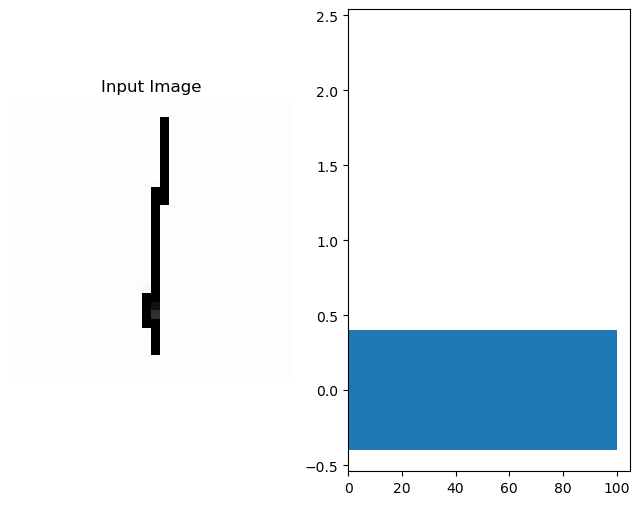

In [47]:
predict_new_image('/Users/rakan/Downloads/Untitled.jpg', best_model, arabic_labels)

In [48]:

processed_image = preprocess_new_image('/Users/rakan/Downloads/Untitled.jpg')

# Make prediction
prediction = model.predict(processed_image)
predicted_class = np.argmax(prediction)
confidence = np.max(prediction) * 100



print(predicted_class, prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
17 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]


TypeError: unhashable type: 'numpy.ndarray'

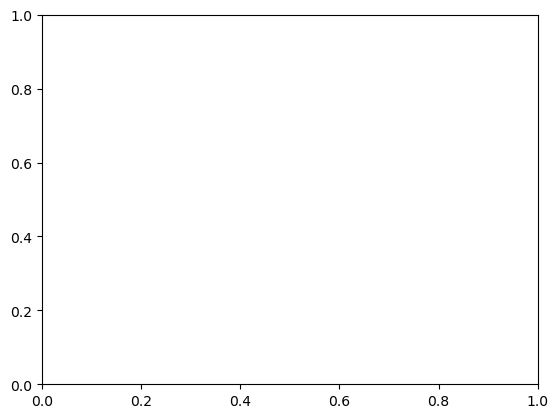

In [50]:
#image_path = '/Users/rakan/Desktop/Screenshot 2024-12-05 at 1.04.40 PM.png'

image_path = '/Users/rakan/Downloads/Untitled.jpg'
# Load and preprocess a new image
img = tf.keras.preprocessing.image.load_img(
    image_path, color_mode='grayscale', target_size=(32, 32)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = img_array / 255.0
img_array = img_array.reshape((1, 32, 32, 1))

plt.imshow('image', img_array)


# # Make prediction
# prediction = best_model.predict(processed_image)
# predicted_class = np.argmax(prediction)
# confidence = np.max(prediction) * 100

# # Display results
# plt.figure(figsize=(6, 6))
# plt.imshow(processed_image.reshape(32, 32), cmap='gray')
# plt.title(f'Predicted: {arabic_labels[predicted_class]}\nConfidence: {confidence:.2f}%')
# plt.axis('off')
# plt.show()
    
# #predict_new_image(image_path)

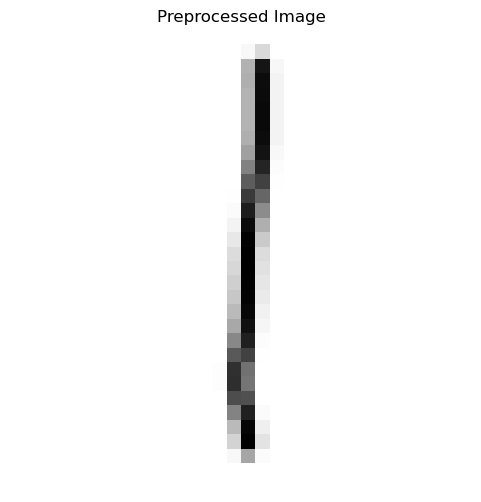


Prediction Results:
Predicted Letter: ه
Confidence: 95.21%

Top 3 Predictions:
1. Letter: ه (Confidence: 95.21%)


IndexError: list index out of range

In [58]:
# Load and display the image
image_path = '/Users/rakan/Downloads/Untitled.jpg'

# Load and preprocess the image
img = tf.keras.preprocessing.image.load_img(
    image_path, 
    color_mode='grayscale', 
    interpolation='hamming',
    target_size=(32, 32)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = img_array / 255.0
img_array = img_array.reshape((1, 32, 32, 1))

# Display the preprocessed image
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.title('Preprocessed Image')
plt.axis('off')
plt.show()

# Make prediction
prediction = best_model.predict(img_array, verbose=0)
predicted_class = np.argmax(prediction)
confidence = np.max(prediction) * 100

# Print results
print(f"\nPrediction Results:")
print(f"Predicted Letter: {arabic_labels[predicted_class]}")
print(f"Confidence: {confidence:.2f}%")

# Get top 3 predictions
top_3_indices = np.argsort(prediction[0])[-3:][::-1]
print("\nTop 3 Predictions:")
for i, idx in enumerate(top_3_indices, 1):
    conf = prediction[0][idx] * 100
    print(f"{i}. Letter: {arabic_labels[idx]} (Confidence: {conf:.2f}%)")


Sample 1:
True Label: ز
Predicted: ا (99.9%)
Top 3 predictions:
  1. ا: 99.9%
  2. د: 0.1%
  3. ز: 0.0%

Sample 2:
True Label: ظ
Predicted: ا (99.9%)
Top 3 predictions:
  1. ا: 99.9%
  2. د: 0.1%
  3. ز: 0.0%

Sample 3:
True Label: خ
Predicted: ا (99.9%)
Top 3 predictions:
  1. ا: 99.9%
  2. د: 0.1%
  3. ز: 0.0%

Sample 4:
True Label: د
Predicted: ا (99.9%)
Top 3 predictions:
  1. ا: 99.9%
  2. د: 0.1%
  3. ز: 0.0%

Sample 5:
True Label: ك
Predicted: ا (99.9%)
Top 3 predictions:
  1. ا: 99.9%
  2. د: 0.1%
  3. ز: 0.0%


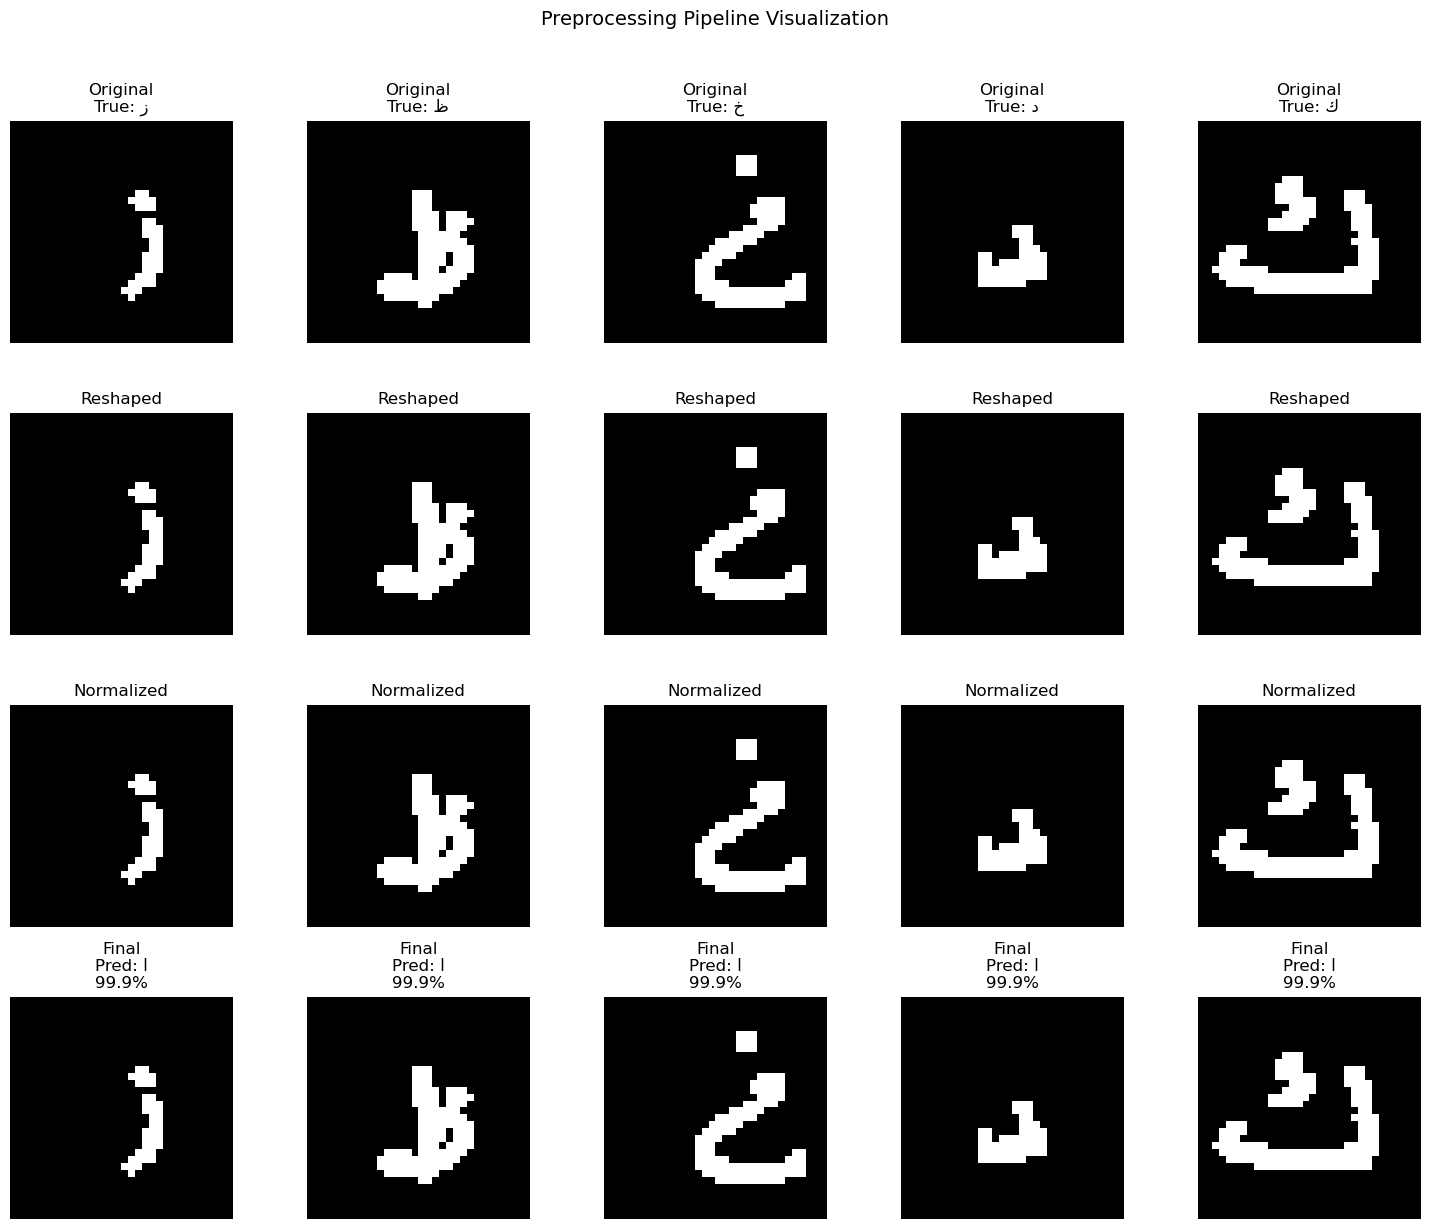

In [59]:
def visualize_preprocessing_pipeline(X_train, y_train, model, arabic_labels, n_samples=5):
    # Randomly select n_samples
    indices = np.random.choice(len(X_train), n_samples, replace=False)
    
    # Create a figure with rows for each step in the pipeline
    fig, axes = plt.subplots(4, n_samples, figsize=(15, 12))
    
    for i, idx in enumerate(indices):
        # Original image
        original_img = X_train[idx]
        axes[0, i].imshow(original_img.reshape(32, 32), cmap='gray')
        axes[0, i].set_title(f'Original\nTrue: {arabic_labels[np.argmax(y_train[idx])]}')
        axes[0, i].axis('off')
        
        # After reshaping to (32, 32, 1)
        reshaped_img = original_img.reshape(32, 32, 1)
        axes[1, i].imshow(reshaped_img.reshape(32, 32), cmap='gray')
        axes[1, i].set_title('Reshaped')
        axes[1, i].axis('off')
        
        # After normalization
        normalized_img = reshaped_img / 255.0
        axes[2, i].imshow(normalized_img.reshape(32, 32), cmap='gray')
        axes[2, i].set_title('Normalized')
        axes[2, i].axis('off')
        
        # Add batch dimension and predict
        batch_img = normalized_img.reshape(1, 32, 32, 1)
        prediction = model.predict(batch_img, verbose=0)
        pred_class = np.argmax(prediction)
        confidence = np.max(prediction) * 100
        
        # Show final preprocessed image with prediction
        axes[3, i].imshow(batch_img.reshape(32, 32), cmap='gray')
        axes[3, i].set_title(f'Final\nPred: {arabic_labels[pred_class]}\n{confidence:.1f}%')
        axes[3, i].axis('off')
        
        # Print detailed predictions
        print(f"\nSample {i+1}:")
        print(f"True Label: {arabic_labels[np.argmax(y_train[idx])]}")
        print(f"Predicted: {arabic_labels[pred_class]} ({confidence:.1f}%)")
        print("Top 3 predictions:")
        top_3 = np.argsort(prediction[0])[-3:][::-1]
        for j, idx in enumerate(top_3, 1):
            conf = prediction[0][idx] * 100
            print(f"  {j}. {arabic_labels[idx]}: {conf:.1f}%")
    
    plt.suptitle('Preprocessing Pipeline Visualization', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_preprocessing_pipeline(X_train, y_train, best_model, arabic_labels)


Sample 1:
True Label: ع
Predicted: ع (97.3%)
Top 3 predictions:
  1. ع: 97.3%
  2. ح: 1.3%
  3. غ: 0.8%

Sample 2:
True Label: ض
Predicted: ض (81.6%)
Top 3 predictions:
  1. ض: 81.6%
  2. ش: 16.2%
  3. ف: 1.0%

Sample 3:
True Label: ث
Predicted: ث (90.8%)
Top 3 predictions:
  1. ث: 90.8%
  2. ت: 8.5%
  3. ك: 0.5%

Sample 4:
True Label: ج
Predicted: ج (96.1%)
Top 3 predictions:
  1. ج: 96.1%
  2. ح: 3.8%
  3. خ: 0.0%

Sample 5:
True Label: ظ
Predicted: ظ (96.8%)
Top 3 predictions:
  1. ظ: 96.8%
  2. ش: 1.9%
  3. ض: 0.4%


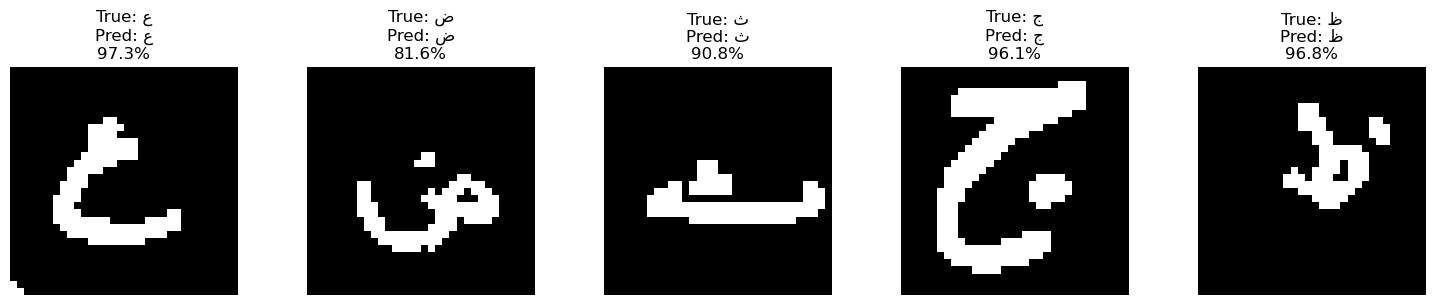

In [60]:
def visualize_sample_predictions(X_train, y_train, model, arabic_labels, n_samples=5):
    # Randomly select n_samples
    indices = np.random.choice(len(X_train), n_samples, replace=False)
    
    # Create a figure
    plt.figure(figsize=(15, 3))
    
    for i, idx in enumerate(indices):
        # Get the image and true label
        img = X_train[idx]
        true_label = arabic_labels[np.argmax(y_train[idx])]
        
        # Make prediction
        prediction = model.predict(img.reshape(1, 32, 32, 1), verbose=0)
        pred_class = np.argmax(prediction)
        confidence = np.max(prediction) * 100
        
        # Plot
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img.reshape(32, 32), cmap='gray')
        plt.title(f'True: {true_label}\nPred: {arabic_labels[pred_class]}\n{confidence:.1f}%')
        plt.axis('off')
        
        # Print detailed predictions
        print(f"\nSample {i+1}:")
        print(f"True Label: {true_label}")
        print(f"Predicted: {arabic_labels[pred_class]} ({confidence:.1f}%)")
        print("Top 3 predictions:")
        top_3 = np.argsort(prediction[0])[-3:][::-1]
        for j, idx in enumerate(top_3, 1):
            conf = prediction[0][idx] * 100
            print(f"  {j}. {arabic_labels[idx]}: {conf:.1f}%")
    
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_sample_predictions(X_train, y_train, best_model, arabic_labels)


Sample 1:
True Label: ذ
Original Prediction: ذ (99.1%)
Reshaped Prediction: ذ (99.1%)
Normalized Prediction: ا (99.9%)
Final Prediction: ا (99.9%)

Sample 2:
True Label: غ
Original Prediction: غ (98.1%)
Reshaped Prediction: غ (98.1%)
Normalized Prediction: ا (99.9%)
Final Prediction: ا (99.9%)


IndexError: list index out of range

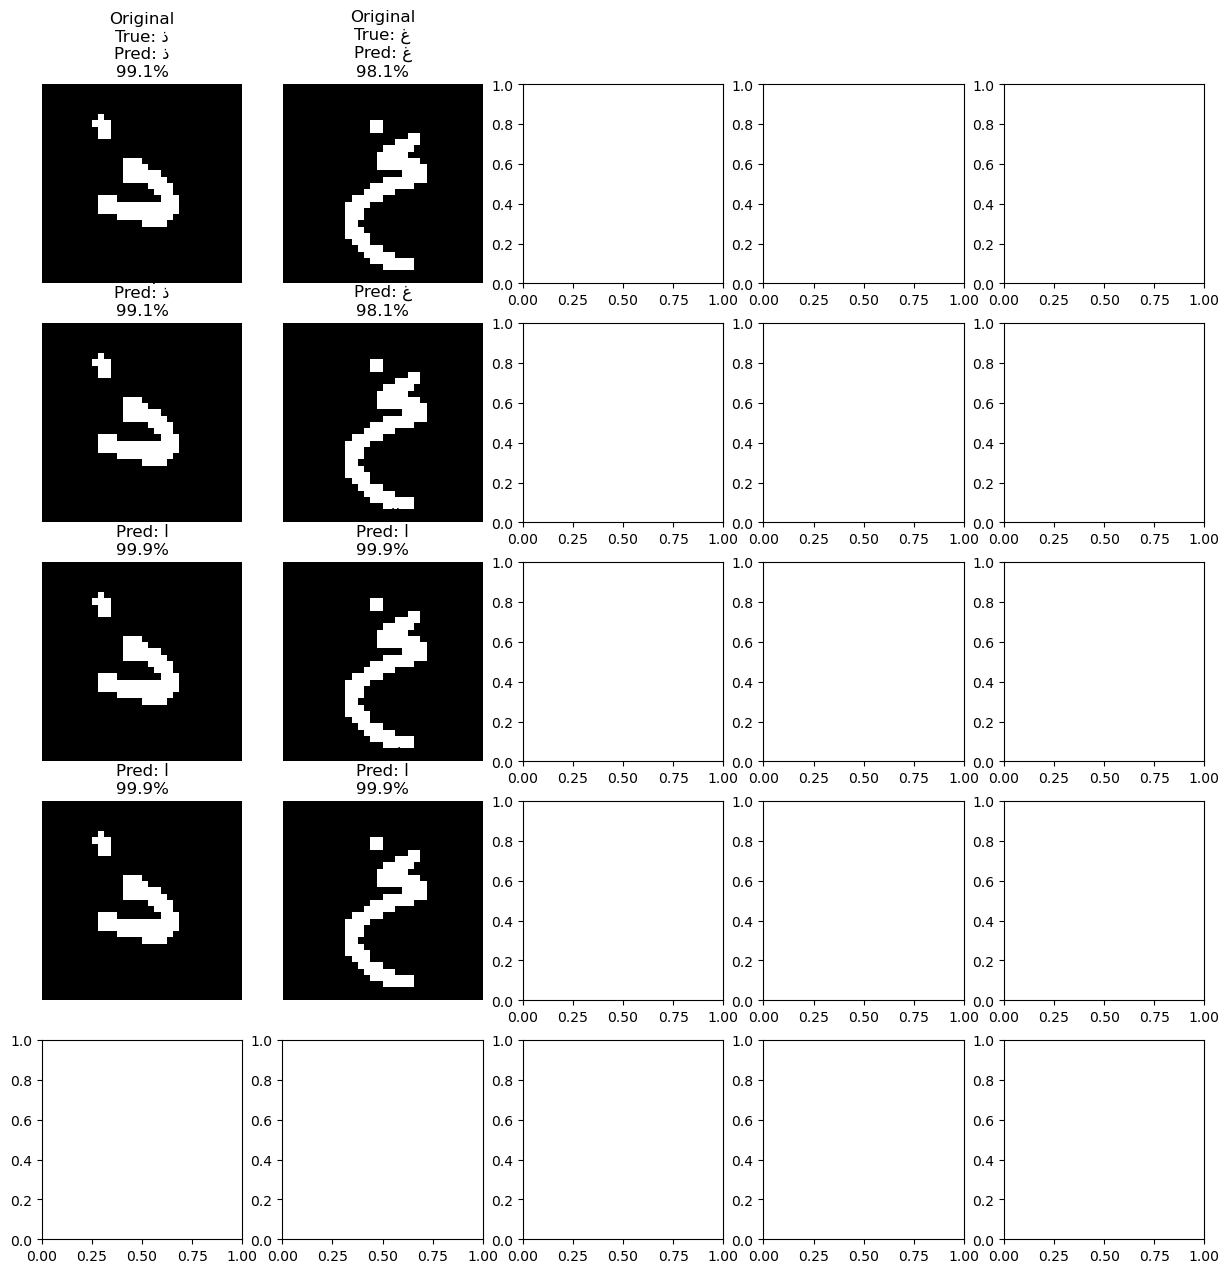

In [61]:
def visualize_preprocessing_pipeline_with_predictions(X_train, y_train, model, arabic_labels, n_samples=5):
    # Randomly select n_samples
    indices = np.random.choice(len(X_train), n_samples, replace=False)
    
    # Create a figure with rows for each step in the pipeline
    fig, axes = plt.subplots(5, n_samples, figsize=(15, 15))
    
    for i, idx in enumerate(indices):
        # Original image
        original_img = X_train[idx]
        true_label = arabic_labels[np.argmax(y_train[idx])]
        
        # Direct prediction on original image
        pred_original = model.predict(original_img.reshape(1, 32, 32, 1), verbose=0)
        pred_class_original = np.argmax(pred_original)
        confidence_original = np.max(pred_original) * 100
        
        axes[0, i].imshow(original_img.reshape(32, 32), cmap='gray')
        axes[0, i].set_title(f'Original\nTrue: {true_label}\nPred: {arabic_labels[pred_class_original]}\n{confidence_original:.1f}%')
        axes[0, i].axis('off')
        
        # After reshaping to (32, 32, 1)
        reshaped_img = original_img.reshape(32, 32, 1)
        pred_reshaped = model.predict(reshaped_img.reshape(1, 32, 32, 1), verbose=0)
        pred_class_reshaped = np.argmax(pred_reshaped)
        confidence_reshaped = np.max(pred_reshaped) * 100
        
        axes[1, i].imshow(reshaped_img.reshape(32, 32), cmap='gray')
        axes[1, i].set_title(f'Reshaped\nPred: {arabic_labels[pred_class_reshaped]}\n{confidence_reshaped:.1f}%')
        axes[1, i].axis('off')
        
        # After normalization
        normalized_img = reshaped_img / 255.0
        pred_normalized = model.predict(normalized_img.reshape(1, 32, 32, 1), verbose=0)
        pred_class_normalized = np.argmax(pred_normalized)
        confidence_normalized = np.max(pred_normalized) * 100
        
        axes[2, i].imshow(normalized_img.reshape(32, 32), cmap='gray')
        axes[2, i].set_title(f'Normalized\nPred: {arabic_labels[pred_class_normalized]}\n{confidence_normalized:.1f}%')
        axes[2, i].axis('off')
        
        # Add batch dimension and predict
        batch_img = normalized_img.reshape(1, 32, 32, 1)
        pred_batch = model.predict(batch_img, verbose=0)
        pred_class_batch = np.argmax(pred_batch)
        confidence_batch = np.max(pred_batch) * 100
        
        axes[3, i].imshow(batch_img.reshape(32, 32), cmap='gray')
        axes[3, i].set_title(f'Final\nPred: {arabic_labels[pred_class_batch]}\n{confidence_batch:.1f}%')
        axes[3, i].axis('off')
        
        # Print detailed predictions
        print(f"\nSample {i+1}:")
        print(f"True Label: {true_label}")
        print(f"Original Prediction: {arabic_labels[pred_class_original]} ({confidence_original:.1f}%)")
        print(f"Reshaped Prediction: {arabic_labels[pred_class_reshaped]} ({confidence_reshaped:.1f}%)")
        print(f"Normalized Prediction: {arabic_labels[pred_class_normalized]} ({confidence_normalized:.1f}%)")
        print(f"Final Prediction: {arabic_labels[pred_class_batch]} ({confidence_batch:.1f}%)")
    
    plt.suptitle('Preprocessing Pipeline with Predictions', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_preprocessing_pipeline_with_predictions(X_train, y_train, best_model, arabic_labels)


Sample 1:
True Label: ح
Original range: [0.000, 1.000]
Reshaped range: [0.000, 1.000]
Normalized range: [0.000, 0.004]

Predictions:
Original: ح (66.2%)
Reshaped: ح (66.2%)
Normalized: ا (99.9%)

Sample 2:
True Label: س
Original range: [0.000, 1.000]
Reshaped range: [0.000, 1.000]
Normalized range: [0.000, 0.004]

Predictions:
Original: س (95.9%)
Reshaped: س (95.9%)
Normalized: ا (99.9%)

Sample 3:
True Label: ص
Original range: [0.000, 1.000]
Reshaped range: [0.000, 1.000]
Normalized range: [0.000, 0.004]

Predictions:
Original: ص (50.2%)
Reshaped: ص (50.2%)
Normalized: ا (99.9%)

Sample 4:
True Label: ص
Original range: [0.000, 1.000]
Reshaped range: [0.000, 1.000]
Normalized range: [0.000, 0.004]

Predictions:
Original: ص (97.7%)
Reshaped: ص (97.7%)
Normalized: ا (99.9%)

Sample 5:
True Label: ل
Original range: [0.000, 1.000]
Reshaped range: [0.000, 1.000]
Normalized range: [0.000, 0.004]

Predictions:
Original: ل (98.6%)
Reshaped: ل (98.6%)
Normalized: ا (99.9%)


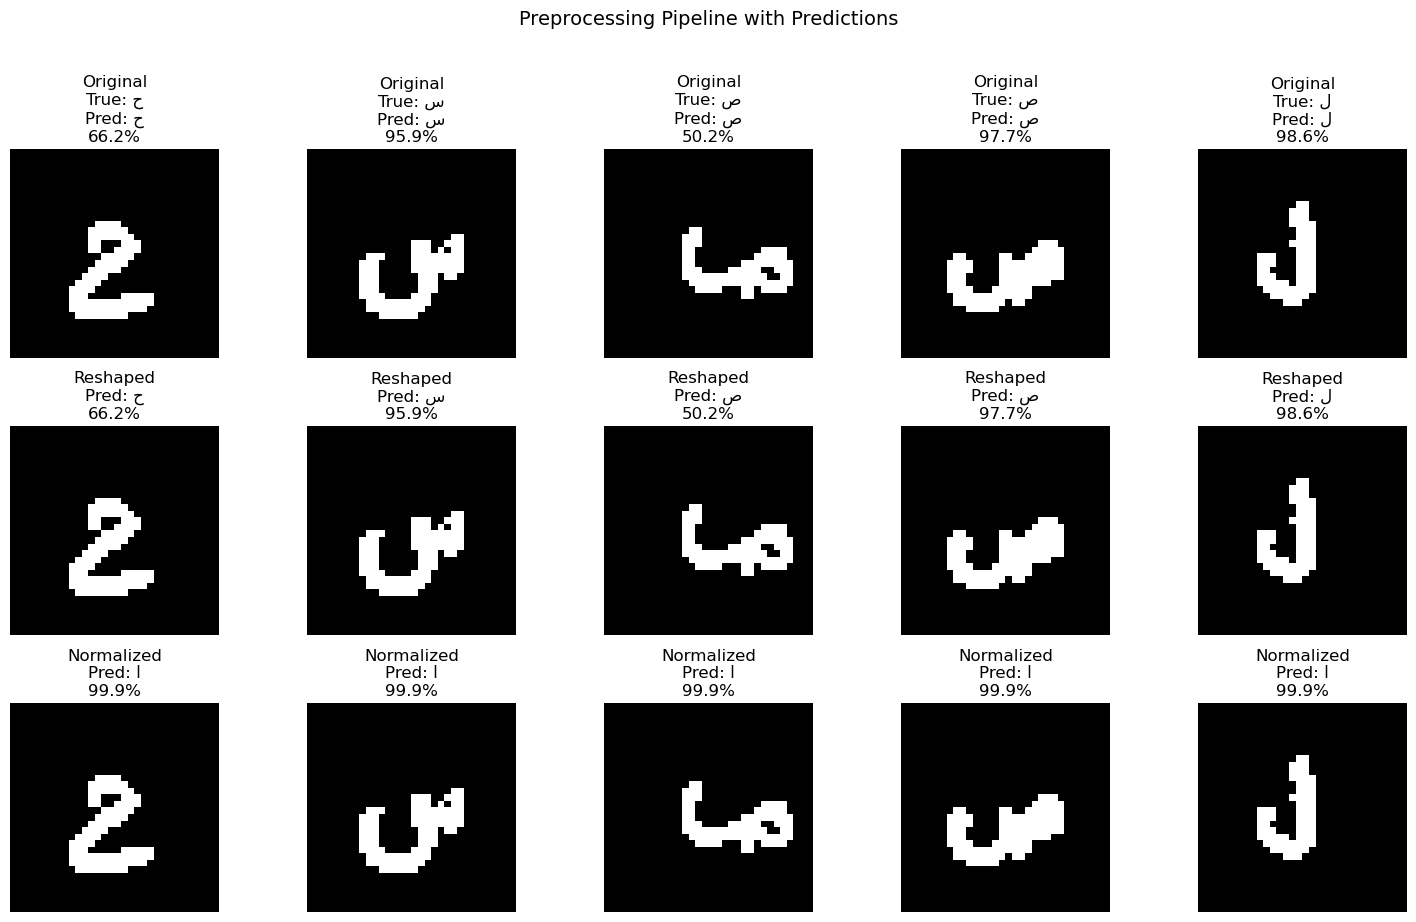

In [63]:
def visualize_preprocessing_pipeline_with_predictions(X_train, y_train, model, arabic_labels, n_samples=5):
    # Randomly select n_samples
    indices = np.random.choice(len(X_train), n_samples, replace=False)
    
    # Create a figure with rows for each step in the pipeline
    fig, axes = plt.subplots(3, n_samples, figsize=(15, 9))
    
    for i, idx in enumerate(indices):
        # Original image
        original_img = X_train[idx]
        true_class = np.argmax(y_train[idx])
        
        # Verify index is within bounds
        if true_class < len(arabic_labels):
            true_label = arabic_labels[true_class]
        else:
            true_label = f"Class {true_class}"
        
        # Direct prediction on original image
        pred_original = model.predict(original_img.reshape(1, 32, 32, 1), verbose=0)
        pred_class_original = np.argmax(pred_original)
        confidence_original = np.max(pred_original) * 100
        pred_label_original = arabic_labels[pred_class_original] if pred_class_original < len(arabic_labels) else f"Class {pred_class_original}"
        
        axes[0, i].imshow(original_img.reshape(32, 32), cmap='gray')
        axes[0, i].set_title(f'Original\nTrue: {true_label}\nPred: {pred_label_original}\n{confidence_original:.1f}%')
        axes[0, i].axis('off')
        
        # After reshaping to (32, 32, 1)
        reshaped_img = original_img.reshape(32, 32, 1)
        pred_reshaped = model.predict(reshaped_img.reshape(1, 32, 32, 1), verbose=0)
        pred_class_reshaped = np.argmax(pred_reshaped)
        confidence_reshaped = np.max(pred_reshaped) * 100
        pred_label_reshaped = arabic_labels[pred_class_reshaped] if pred_class_reshaped < len(arabic_labels) else f"Class {pred_class_reshaped}"
        
        axes[1, i].imshow(reshaped_img.reshape(32, 32), cmap='gray')
        axes[1, i].set_title(f'Reshaped\nPred: {pred_label_reshaped}\n{confidence_reshaped:.1f}%')
        axes[1, i].axis('off')
        
        # After normalization
        normalized_img = reshaped_img / 255.0
        pred_normalized = model.predict(normalized_img.reshape(1, 32, 32, 1), verbose=0)
        pred_class_normalized = np.argmax(pred_normalized)
        confidence_normalized = np.max(pred_normalized) * 100
        pred_label_normalized = arabic_labels[pred_class_normalized] if pred_class_normalized < len(arabic_labels) else f"Class {pred_class_normalized}"
        
        axes[2, i].imshow(normalized_img.reshape(32, 32), cmap='gray')
        axes[2, i].set_title(f'Normalized\nPred: {pred_label_normalized}\n{confidence_normalized:.1f}%')
        axes[2, i].axis('off')
        
        # Print value ranges at each step
        print(f"\nSample {i+1}:")
        print(f"True Label: {true_label}")
        print(f"Original range: [{original_img.min():.3f}, {original_img.max():.3f}]")
        print(f"Reshaped range: [{reshaped_img.min():.3f}, {reshaped_img.max():.3f}]")
        print(f"Normalized range: [{normalized_img.min():.3f}, {normalized_img.max():.3f}]")
        print("\nPredictions:")
        print(f"Original: {pred_label_original} ({confidence_original:.1f}%)")
        print(f"Reshaped: {pred_label_reshaped} ({confidence_reshaped:.1f}%)")
        print(f"Normalized: {pred_label_normalized} ({confidence_normalized:.1f}%)")
    
    plt.suptitle('Preprocessing Pipeline with Predictions', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# Run the visualization with error checking
visualize_preprocessing_pipeline_with_predictions(X_train, y_train, best_model, arabic_labels)

Number of arabic labels: 28
Number of classes in prediction: 29
Top 3 indices: [19 28 13]

Valid indices: [19, 13]


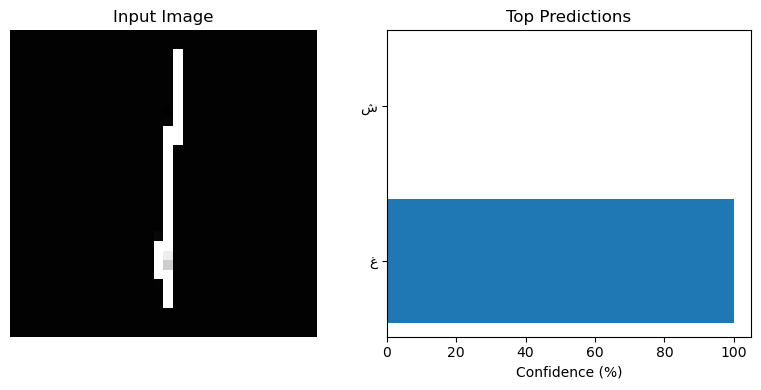


Prediction Results:
1. Letter: غ
   Confidence: 100.00%
2. Letter: ش
   Confidence: 0.00%

Raw prediction values:
Class 19: 100.00%
Class 28: 0.00%
Class 13: 0.00%
Class 1: 0.00%
Class 2: 0.00%


In [66]:
def preprocess_new_image(image_path):
    # Load and preprocess a new image
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        color_mode='grayscale', 
        target_size=(32, 32)
        
    )
    # Invert the image colors (255 - pixel value)
    img = tf.keras.preprocessing.image.array_to_img(255 - tf.keras.preprocessing.image.img_to_array(img))
    # Convert to array (without normalization)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Add batch dimension
    img_array = img_array.reshape((1, 32, 32, 1))
    
    return img_array

def predict_new_image(image_path, model, arabic_labels, top_k=3):
    # Print diagnostic information
    print(f"Number of arabic labels: {len(arabic_labels)}")
    
    # Preprocess without normalization
    processed_image = preprocess_new_image(image_path)
    
    # Make prediction
    predictions = model.predict(processed_image, verbose=0)
    print(f"Number of classes in prediction: {len(predictions[0])}")
    
    # Get top k predictions
    top_k_indices = np.argsort(predictions[0])[-top_k:][::-1]
    print(f"Top {top_k} indices: {top_k_indices}")
    
    # Ensure indices are within bounds
    valid_indices = [i for i in top_k_indices if i < len(arabic_labels)]
    if len(valid_indices) < len(top_k_indices):
        print("\nWarning: Some predicted classes are out of range!")
        print(f"Valid indices: {valid_indices}")
    
    top_k_probabilities = predictions[0][valid_indices]
    
    # Display results
    plt.figure(figsize=(8, 4))
    
    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(processed_image.reshape(32, 32), cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    # Plot the predictions
    plt.subplot(1, 2, 2)
    plt.barh(range(len(valid_indices)), top_k_probabilities * 100)
    plt.yticks(range(len(valid_indices)), [arabic_labels[i] for i in valid_indices])
    plt.xlabel('Confidence (%)')
    plt.title('Top Predictions')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\nPrediction Results:")
    for i, (idx, prob) in enumerate(zip(valid_indices, top_k_probabilities), 1):
        print(f"{i}. Letter: {arabic_labels[idx]}")
        print(f"   Confidence: {prob * 100:.2f}%")
        
    # Print raw predictions for debugging
    print("\nRaw prediction values:")
    top_raw_indices = np.argsort(predictions[0])[-5:][::-1]  # Show top 5 raw predictions
    for idx in top_raw_indices:
        print(f"Class {idx}: {predictions[0][idx]*100:.2f}%")

# Test the updated function
image_path = '/Users/rakan/Downloads/Untitled.jpg'
predict_new_image(image_path, best_model, arabic_labels)

In [5]:
best_model = tf.keras.models.load_model('best_arabic_model.keras')

# Corrected Arabic letter labels
arabic_labels = ['ي', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 
                'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 
                'ك', 'ل', 'م', 'ن', 'ه', 'و']


def analyze_data_and_predictions(X_train, y_train, image_path, model, arabic_labels):
    # 1. Print label mapping
    print("Label Mapping:")
    for i, label in enumerate(arabic_labels):
        print(f"Index {i}: {label}")
    
    # 2. Show a training example of 'ا' (alif)
    alif_indices = np.where(np.argmax(y_train, axis=1) == 0)[0]  # 0 should be 'ا'
    if len(alif_indices) > 0:
        alif_example = X_train[alif_indices[0]]
        
        # 3. Compare preprocessing between training and new image
        # Load new image
        new_img = preprocess_new_image(image_path)
        
        # Plot comparison
        plt.figure(figsize=(12, 4))
        
        # Plot training alif
        plt.subplot(1, 3, 1)
        plt.imshow(alif_example.reshape(32, 32), cmap='gray')
        plt.title(f"Training 'ا'\nValue Range: [{alif_example.min():.2f}, {alif_example.max():.2f}]")
        plt.axis('off')
        
        # Plot new image
        plt.subplot(1, 3, 2)
        plt.imshow(new_img.reshape(32, 32), cmap='gray')
        plt.title(f"New Image\nValue Range: [{new_img.min():.2f}, {new_img.max():.2f}]")
        plt.axis('off')
        
        # Plot value distributions
        plt.subplot(1, 3, 3)
        plt.hist(alif_example.ravel(), bins=50, alpha=0.5, label='Training ا')
        plt.hist(new_img.ravel(), bins=50, alpha=0.5, label='New Image')
        plt.title('Pixel Value Distribution')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print predictions for both
        print("\nPredictions Comparison:")
        print("Training 'ا' prediction:")
        pred_train = model.predict(alif_example.reshape(1, 32, 32, 1), verbose=0)
        top_train = np.argsort(pred_train[0])[-3:][::-1]
        for idx in top_train:
            print(f"Class {idx} ({arabic_labels[idx]}): {pred_train[0][idx]*100:.2f}%")
            
        print("\nNew image prediction:")
        pred_new = model.predict(new_img, verbose=0)
        top_new = np.argsort(pred_new[0])[-3:][::-1]
        for idx in top_new:
            print(f"Class {idx} ({arabic_labels[idx]}): {pred_new[0][idx]*100:.2f}%")
        
        # Print value statistics
        print("\nValue Statistics:")
        print(f"Training 'ا': mean={alif_example.mean():.2f}, std={alif_example.std():.2f}")
        print(f"New Image: mean={new_img.mean():.2f}, std={new_img.std():.2f}")

# Run the analysis
image_path = '/Users/rakan/Downloads/Untitled.jpg'
analyze_data_and_predictions(X_train, y_train, image_path, best_model, arabic_labels)

Label Mapping:
Index 0: ي
Index 1: ا
Index 2: ب
Index 3: ت
Index 4: ث
Index 5: ج
Index 6: ح
Index 7: خ
Index 8: د
Index 9: ذ
Index 10: ر
Index 11: ز
Index 12: س
Index 13: ش
Index 14: ص
Index 15: ض
Index 16: ط
Index 17: ظ
Index 18: ع
Index 19: غ
Index 20: ف
Index 21: ق
Index 22: ك
Index 23: ل
Index 24: م
Index 25: ن
Index 26: ه
Index 27: و


In [6]:
arabic_labels = [
    'ي', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 
    'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 
    'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و'
]

Number of labels: 28
Prediction shape: (1, 29)
Raw top 3 indices: [17 28 13]
Valid indices: [17, 13]


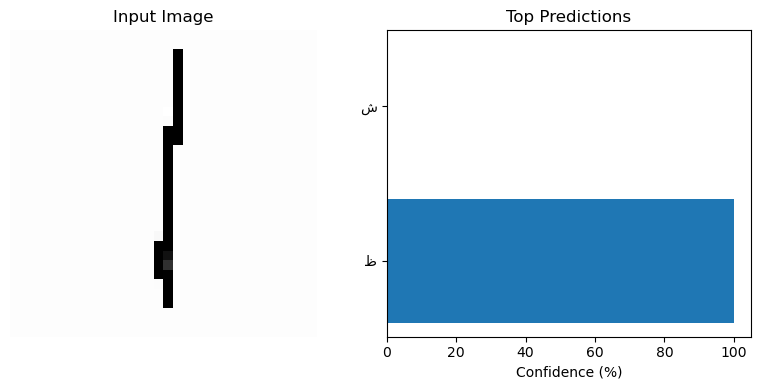


Prediction Results:
1. Letter: ظ
   Confidence: 100.00%
2. Letter: ش
   Confidence: 0.00%

Raw top 5 predictions:
Class 17: 100.00%
Class 28: 0.00%
Class 13: 0.00%
Class 1: 0.00%
Class 2: 0.00%


In [9]:
def preprocess_new_image(image_path):
    # Load and preprocess a new image
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        color_mode='grayscale', 
        target_size=(32, 32)
    )
    
    # Convert to array (without normalization)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Add batch dimension
    img_array = img_array.reshape((1, 32, 32, 1))
    
    return img_array

def predict_new_image(image_path, model, arabic_labels, top_k=3):
    # Print diagnostic information
    print(f"Number of labels: {len(arabic_labels)}")
    
    # Preprocess without normalization
    processed_image = preprocess_new_image(image_path)
    
    # Make prediction
    predictions = model.predict(processed_image, verbose=0)
    print(f"Prediction shape: {predictions.shape}")
    
    # Get top k predictions and ensure they're within bounds
    top_k_indices = np.argsort(predictions[0])[-top_k:][::-1]
    print(f"Raw top {top_k} indices: {top_k_indices}")
    
    # Filter indices that are within bounds
    valid_indices = [i for i in top_k_indices if i < len(arabic_labels)]
    print(f"Valid indices: {valid_indices}")
    
    if not valid_indices:
        print("Warning: No valid predictions within label range!")
        return
    
    # Display results
    plt.figure(figsize=(8, 4))
    
    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(processed_image.reshape(32, 32), cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    # Plot the predictions
    plt.subplot(1, 2, 2)
    valid_probs = [predictions[0][i] * 100 for i in valid_indices]
    plt.barh(range(len(valid_indices)), valid_probs)
    plt.yticks(range(len(valid_indices)), [arabic_labels[i] for i in valid_indices])
    plt.xlabel('Confidence (%)')
    plt.title('Top Predictions')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\nPrediction Results:")
    for i, (idx, prob) in enumerate(zip(valid_indices, valid_probs), 1):
        print(f"{i}. Letter: {arabic_labels[idx]}")
        print(f"   Confidence: {prob:.2f}%")
    
    # Print raw predictions for debugging
    print("\nRaw top 5 predictions:")
    top_5_indices = np.argsort(predictions[0])[-5:][::-1]
    for idx in top_5_indices:
        print(f"Class {idx}: {predictions[0][idx]*100:.2f}%")

# Define the correct arabic labels
arabic_labels = [
    'ي', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 
    'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 
    'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و'
]

# Test the updated function
image_path = '/Users/rakan/Downloads/Untitled.jpg'
predict_new_image(image_path, best_model, arabic_labels)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Classification Report:
              precision    recall  f1-score   support

           ي       0.97      1.00      0.98       120
           ا       0.97      0.97      0.97       120
           ب       0.78      0.94      0.85       120
           ت       0.91      0.88      0.89       120
           ث       0.78      0.96      0.86       120
           ج       0.87      0.86      0.86       120
           ح       0.92      0.82      0.86       120
           خ       0.87      0.93      0.90       120
           د       0.89      0.81      0.85       120
           ذ       0.86      0.89      0.87       120
           ر       0.85      0.82      0.84       120
           ز       0.91      0.89      0.90       120
           س       0.83      0.96      0.89       120
           ش       0.89      0.88      0.89       120
           ص       0.91      0.85      0.88       120
           ض       0.94      0.90      0.92       120
           ط    

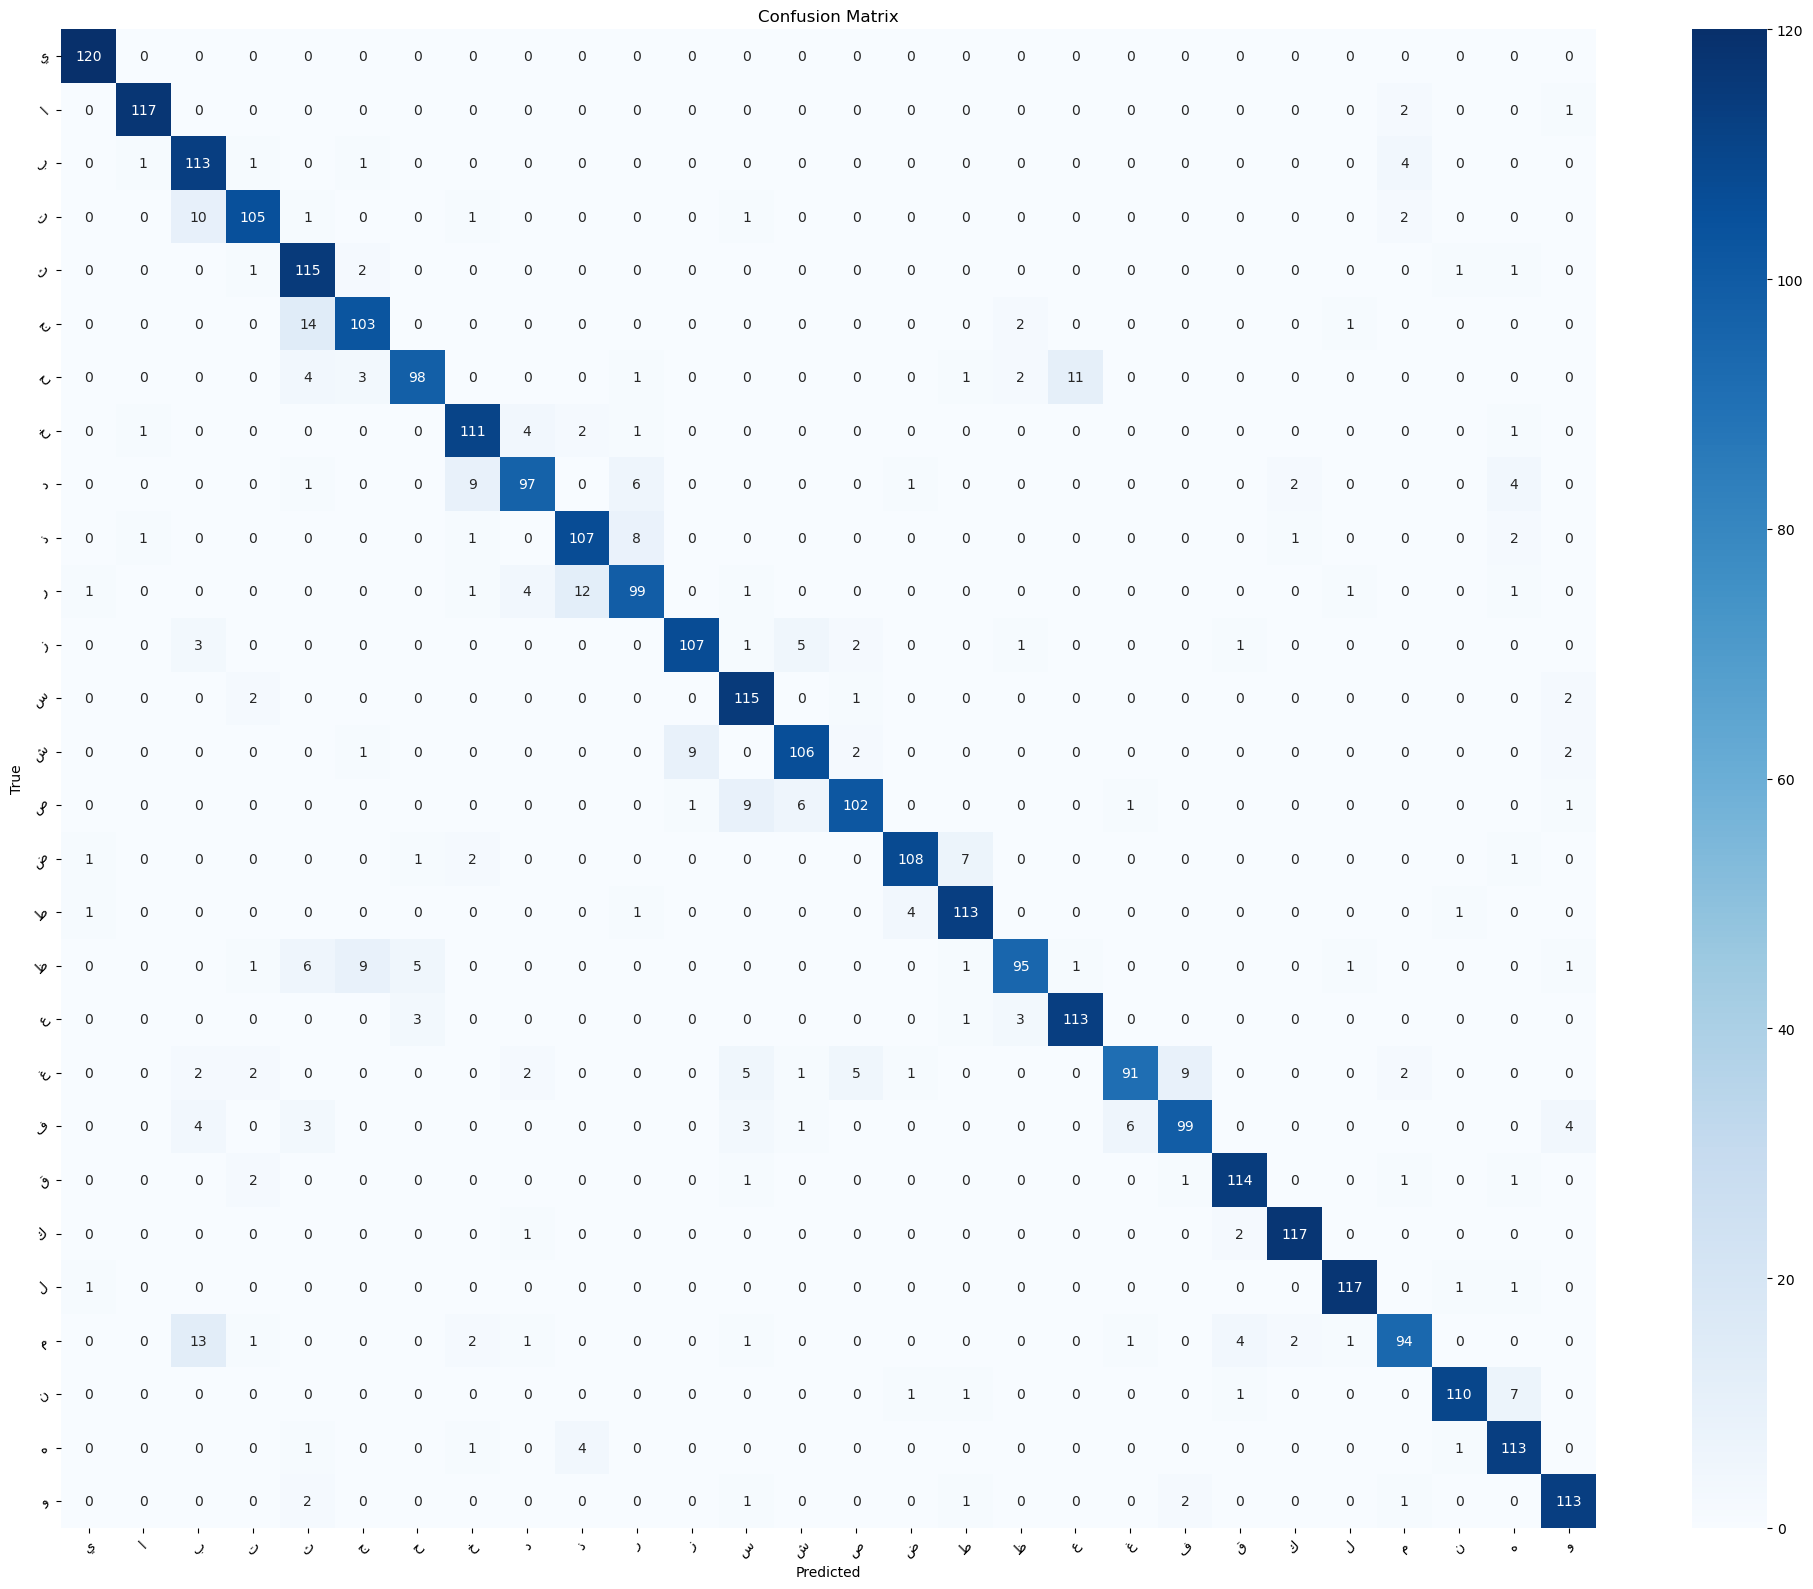


Detailed metrics for 'ا' (alif):
True positives: 117
False negatives: 3
False positives: 3

Checking misclassified 'ا' examples...


In [12]:
def evaluate_model_on_test(X_test, y_test, model, arabic_labels):
    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=arabic_labels))
    
    # Confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=arabic_labels,
                yticklabels=arabic_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print specific metrics for 'ا' (alif)
    alif_idx = arabic_labels.index('ا')
    print(f"\nDetailed metrics for 'ا' (alif):")
    print(f"True positives: {cm[alif_idx, alif_idx]}")
    print(f"False negatives: {sum(cm[alif_idx]) - cm[alif_idx, alif_idx]}")
    print(f"False positives: {sum(cm[:, alif_idx]) - cm[alif_idx, alif_idx]}")
    
    # Show examples of misclassifications
    print("\nChecking misclassified 'ا' examples...")
    misclassified_indices = np.where((y_true_classes == alif_idx) & (y_pred_classes != alif_idx))[0]
    
    if len(misclassified_indices) > 0:
        n_examples = min(5, len(misclassified_indices))
        plt.figure(figsize=(15, 3))
        for i in range(n_examples):
            plt.subplot(1, n_examples, i + 1)
            idx = misclassified_indices[i]
            plt.imshow(X_test[idx].reshape(32, 32), cmap='gray')
            plt.title(f'True: ا\nPred: {arabic_labels[y_pred_classes[idx]]}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# Evaluate the model
evaluate_model_on_test(X_test, y_test, best_model, arabic_labels)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


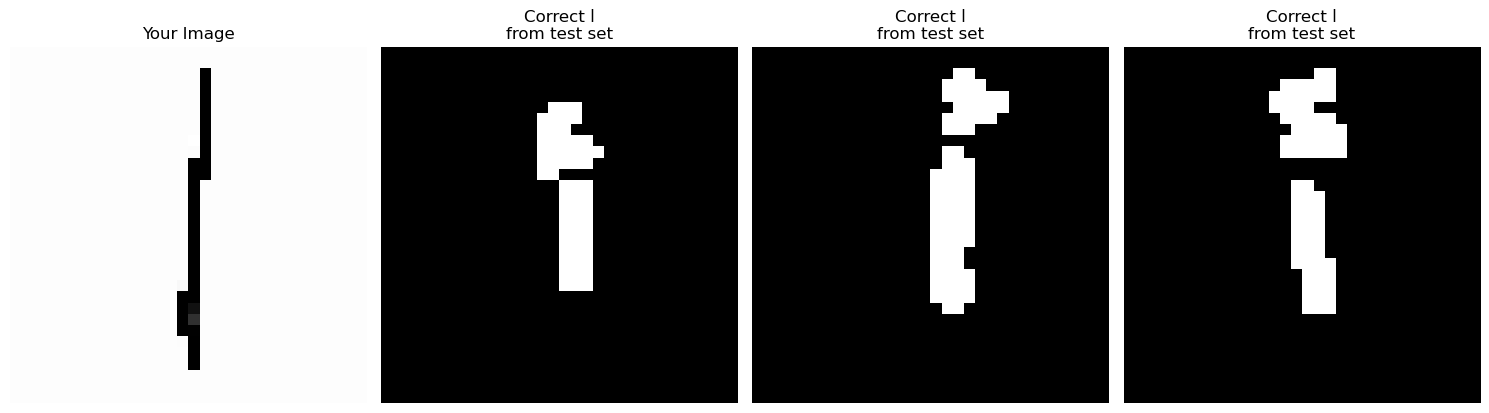


Pixel Value Statistics:
Your image: mean=235.09, std=37.86, range=[26.00, 244.00]
Test alif: mean=0.06, std=0.23, range=[0.00, 1.00]


In [13]:
def analyze_image_characteristics(image_path, X_test, y_test, arabic_labels, model):
    # Load and process your image
    new_img = preprocess_new_image(image_path)
    
    # Find some correct 'ا' predictions from test set
    alif_idx = arabic_labels.index('ا')
    y_pred_test = np.argmax(model.predict(X_test), axis=1)
    y_true_test = np.argmax(y_test, axis=1)
    correct_alifs = np.where((y_true_test == alif_idx) & (y_pred_test == alif_idx))[0]
    
    # Compare characteristics
    plt.figure(figsize=(15, 5))
    
    # Your image
    plt.subplot(1, 4, 1)
    plt.imshow(new_img.reshape(32, 32), cmap='gray')
    plt.title('Your Image')
    plt.axis('off')
    
    # Show 3 correct examples from test set
    for i, idx in enumerate(correct_alifs[:3], 2):
        plt.subplot(1, 4, i)
        plt.imshow(X_test[idx].reshape(32, 32), cmap='gray')
        plt.title(f'Correct ا\nfrom test set')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print value statistics
    print("\nPixel Value Statistics:")
    print(f"Your image: mean={new_img.mean():.2f}, std={new_img.std():.2f}, range=[{new_img.min():.2f}, {new_img.max():.2f}]")
    test_alif = X_test[correct_alifs[0]]
    print(f"Test alif: mean={test_alif.mean():.2f}, std={test_alif.std():.2f}, range=[{test_alif.min():.2f}, {test_alif.max():.2f}]")

# Analyze your image
image_path = '/Users/rakan/Downloads/Untitled.jpg'
analyze_image_characteristics(image_path, X_test, y_test, arabic_labels, best_model)

Number of labels: 28
Prediction shape: (1, 29)
Raw top 3 indices: [26 17 28]
Valid indices: [26, 17]


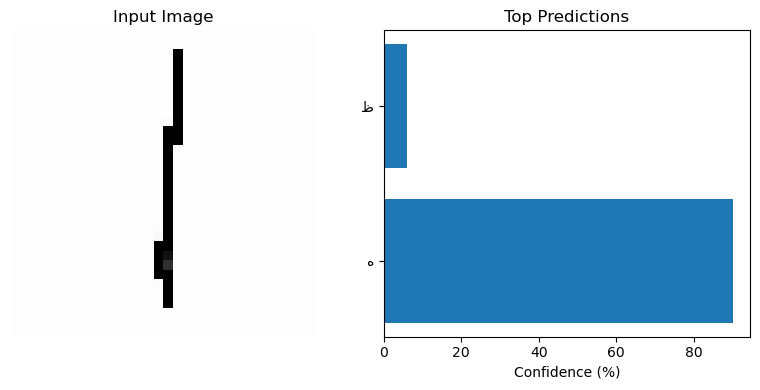


Prediction Results:
1. Letter: ه
   Confidence: 90.04%
2. Letter: ظ
   Confidence: 6.04%

Raw top 5 predictions:
Class 26 (ه): 90.04%
Class 17 (ظ): 6.04%
Class 28 (Unknown (index 28)): 1.91%
Class 19 (غ): 1.27%
Class 7 (خ): 0.41%


In [15]:
def preprocess_new_image(image_path):
    # Load and preprocess a new image
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        color_mode='grayscale', 
        target_size=(32, 32)
    )
    
    # Convert to array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Normalize to [0,1] range
    img_array = img_array / 255.0
    
    # Add batch dimension
    img_array = img_array.reshape((1, 32, 32, 1))
    
    return img_array

def predict_new_image(image_path, model, arabic_labels, top_k=3):
    # Print diagnostic information
    print(f"Number of labels: {len(arabic_labels)}")
    
    # Preprocess with normalization
    processed_image = preprocess_new_image(image_path)
    
    # Make prediction
    predictions = model.predict(processed_image, verbose=0)
    print(f"Prediction shape: {predictions.shape}")
    
    # Get top k predictions and ensure they're within bounds
    top_k_indices = np.argsort(predictions[0])[-top_k:][::-1]
    print(f"Raw top {top_k} indices: {top_k_indices}")
    
    # Filter indices that are within bounds
    valid_indices = [i for i in top_k_indices if i < len(arabic_labels)]
    print(f"Valid indices: {valid_indices}")
    
    if not valid_indices:
        print("Warning: No valid predictions within label range!")
        return
    
    # Display results
    plt.figure(figsize=(8, 4))
    
    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(processed_image.reshape(32, 32), cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    # Plot the predictions
    plt.subplot(1, 2, 2)
    valid_probs = [predictions[0][i] * 100 for i in valid_indices]
    plt.barh(range(len(valid_indices)), valid_probs)
    plt.yticks(range(len(valid_indices)), [arabic_labels[i] for i in valid_indices])
    plt.xlabel('Confidence (%)')
    plt.title('Top Predictions')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\nPrediction Results:")
    for i, (idx, prob) in enumerate(zip(valid_indices, valid_probs), 1):
        print(f"{i}. Letter: {arabic_labels[idx]}")
        print(f"   Confidence: {prob:.2f}%")
    
    # Print raw predictions for debugging
    print("\nRaw top 5 predictions:")
    top_5_indices = np.argsort(predictions[0])[-5:][::-1]
    for idx in top_5_indices:
        if idx < len(arabic_labels):
            label = arabic_labels[idx]
        else:
            label = f"Unknown (index {idx})"
        print(f"Class {idx} ({label}): {predictions[0][idx]*100:.2f}%")

# Test the updated function
image_path = '/Users/rakan/Downloads/Untitled.jpg'
predict_new_image(image_path, best_model, arabic_labels)

Original Image:


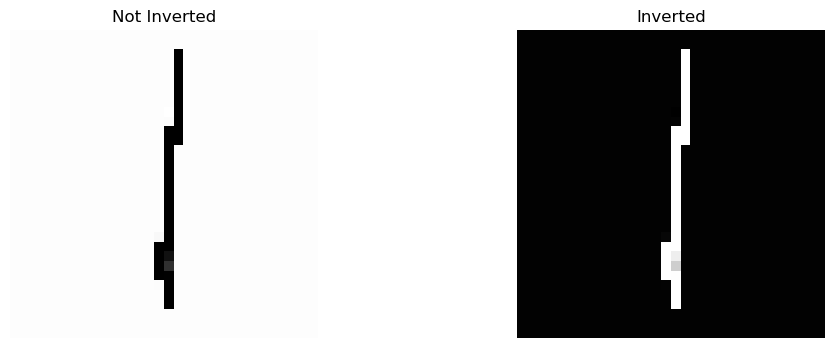


Predictions for Original:

Predictions for Inverted:

Top 3 predictions (Original):
ه: 90.04%
ظ: 6.04%

Top 3 predictions (Inverted):
ا: 96.74%
ز: 2.73%
م: 0.31%

Confidence for 'ا':
Original: 0.00%
Inverted: 96.74%


In [16]:
def preprocess_new_image(image_path, invert=None):
    # Load and preprocess a new image
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        color_mode='grayscale', 
        target_size=(32, 32)
    )
    
    # Convert to array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Normalize to [0,1] range
    img_array = img_array / 255.0
    
    # Auto-detect if we should invert based on mean pixel value
    if invert is None:
        # If mean is > 0.5, image is likely white background with dark text
        invert = img_array.mean() > 0.5
    
    # Invert if needed (1 - x inverts normalized values)
    if invert:
        img_array = 1 - img_array
    
    # Add batch dimension
    img_array = img_array.reshape((1, 32, 32, 1))
    
    return img_array

def predict_with_both_orientations(image_path, model, arabic_labels):
    # Try both normal and inverted
    print("Original Image:")
    img_normal = preprocess_new_image(image_path, invert=False)
    img_inverted = preprocess_new_image(image_path, invert=True)
    
    # Create figure
    plt.figure(figsize=(12, 4))
    
    # Plot original
    plt.subplot(1, 2, 1)
    plt.imshow(img_normal.reshape(32, 32), cmap='gray')
    plt.title('Not Inverted')
    plt.axis('off')
    
    # Plot inverted
    plt.subplot(1, 2, 2)
    plt.imshow(img_inverted.reshape(32, 32), cmap='gray')
    plt.title('Inverted')
    plt.axis('off')
    
    plt.show()
    
    # Predict on both
    print("\nPredictions for Original:")
    pred_normal = model.predict(img_normal, verbose=0)
    top_3_normal = np.argsort(pred_normal[0])[-3:][::-1]
    
    print("\nPredictions for Inverted:")
    pred_inverted = model.predict(img_inverted, verbose=0)
    top_3_inverted = np.argsort(pred_inverted[0])[-3:][::-1]
    
    # Print results
    print("\nTop 3 predictions (Original):")
    for idx in top_3_normal:
        if idx < len(arabic_labels):
            print(f"{arabic_labels[idx]}: {pred_normal[0][idx]*100:.2f}%")
    
    print("\nTop 3 predictions (Inverted):")
    for idx in top_3_inverted:
        if idx < len(arabic_labels):
            print(f"{arabic_labels[idx]}: {pred_inverted[0][idx]*100:.2f}%")
    
    # Compare with training sample
    alif_idx = arabic_labels.index('ا')
    print(f"\nConfidence for 'ا':")
    print(f"Original: {pred_normal[0][alif_idx]*100:.2f}%")
    print(f"Inverted: {pred_inverted[0][alif_idx]*100:.2f}%")

# Test both orientations
image_path = '/Users/rakan/Downloads/Untitled.jpg'
predict_with_both_orientations(image_path, best_model, arabic_labels)


In [17]:
def preprocess_new_image(image_path):
    # Load and preprocess a new image
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        color_mode='grayscale', 
        target_size=(32, 32)
    )
    
    # Convert to array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Normalize to [0,1] range
    img_array = img_array / 255.0
    
    # If mean pixel value is > 0.5, we have white background and need to invert
    if img_array.mean() > 0.5:
        img_array = 1 - img_array
    
    # Add batch dimension
    img_array = img_array.reshape((1, 32, 32, 1))
    
    return img_array

In [22]:
def predict_new_image(image_path, model, arabic_labels, top_k=3):
    # Print diagnostic information
    print(f"Number of arabic labels: {len(arabic_labels)}")
    
    # Preprocess with automatic inversion
    processed_image = preprocess_new_image(image_path)
    
    # Make prediction
    predictions = model.predict(processed_image, verbose=0)
    print(f"Number of classes in prediction: {len(predictions[0])}")
    
    # Get top k predictions
    top_k_indices = np.argsort(predictions[0])[-top_k:][::-1]
    print(f"Top {top_k} indices: {top_k_indices}")
    
    # Ensure indices are within bounds
    valid_indices = [i for i in top_k_indices if i < len(arabic_labels)]
    if len(valid_indices) < len(top_k_indices):
        print("\nWarning: Some predicted classes are out of range!")
        print(f"Valid indices: {valid_indices}")
    
    top_k_probabilities = predictions[0][valid_indices]
    
    # Display results
    plt.figure(figsize=(8, 4))
    
    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(processed_image.reshape(32, 32), cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    # Plot the predictions
    plt.subplot(1, 2, 2)
    plt.barh(range(len(valid_indices)), top_k_probabilities * 100)
    plt.yticks(range(len(valid_indices)), [arabic_labels[i] for i in valid_indices])
    plt.xlabel('Confidence (%)')
    plt.title('Top Predictions')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\nPrediction Results:")
    for i, (idx, prob) in enumerate(zip(valid_indices, top_k_probabilities), 1):
        print(f"{i}. Letter: {arabic_labels[idx]}")
        print(f"   Confidence: {prob * 100:.2f}%")
    
    print("\nRaw top 5 predictions:")
    top_raw_indices = np.argsort(predictions[0])[-5:][::-1]
    for idx in top_raw_indices:
        if idx < len(arabic_labels):
            label = arabic_labels[idx]
        else:
            label = f"Unknown (index {idx})"
        print(f"Class {idx} ({label}): {predictions[0][idx]*100:.2f}%")

# Test the function
#predict_new_image(image_path, best_model, arabic_labels)

Number of arabic labels: 28
Number of classes in prediction: 29
Top 3 indices: [ 8  2 10]


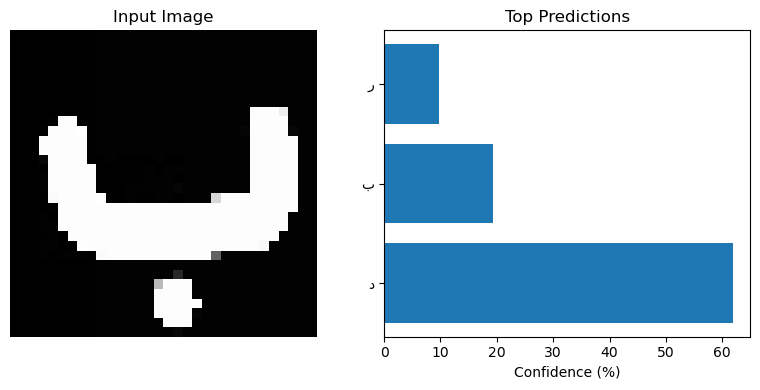


Prediction Results:
1. Letter: د
   Confidence: 61.85%
2. Letter: ب
   Confidence: 19.32%
3. Letter: ر
   Confidence: 9.80%

Raw top 5 predictions:
Class 8 (د): 61.85%
Class 2 (ب): 19.32%
Class 10 (ر): 9.80%
Class 27 (و): 3.34%
Class 9 (ذ): 2.18%


In [20]:
predict_new_image('/Users/rakan/Downloads/IMG_6132.jpg', best_model, arabic_labels)

Number of arabic labels: 28
Number of classes in prediction: 29
Top 3 indices: [ 1 11 24]


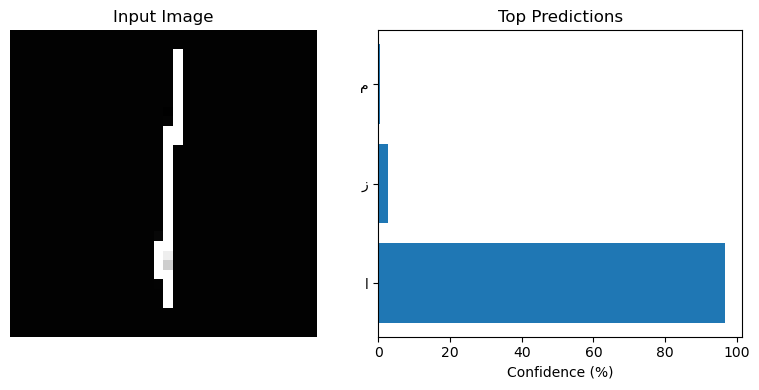


Prediction Results:
1. Letter: ا
   Confidence: 96.74%
2. Letter: ز
   Confidence: 2.73%
3. Letter: م
   Confidence: 0.31%

Raw top 5 predictions:
Class 1 (ا): 96.74%
Class 11 (ز): 2.73%
Class 24 (م): 0.31%
Class 10 (ر): 0.09%
Class 9 (ذ): 0.06%


In [21]:
predict_new_image('/Users/rakan/Downloads/Untitled.jpg', best_model, arabic_labels)

Number of arabic labels: 28
Number of classes in prediction: 29
Top 3 indices: [ 8 27  9]


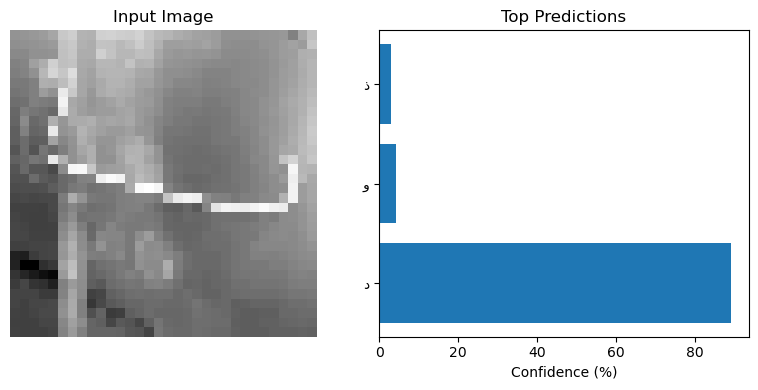


Prediction Results:
1. Letter: د
   Confidence: 89.04%
2. Letter: و
   Confidence: 4.24%
3. Letter: ذ
   Confidence: 2.84%

Raw top 5 predictions:
Class 8 (د): 89.04%
Class 27 (و): 4.24%
Class 9 (ذ): 2.84%
Class 26 (ه): 2.76%
Class 24 (م): 0.27%


In [23]:
predict_new_image('/Users/rakan/Desktop/Screenshot 2024-12-05 at 1.04.40 PM.png', best_model, arabic_labels)

In [24]:
import tensorflow as tf

model_path = '/Users/rakan/Coding/Ironhack AI Engineering Bootcamp/Projects/Project 2 (Arabic MNIST)/best_arabic_model.keras'

try:
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {str(e)}")

Model loaded successfully!
